In [1]:
#!/usr/bin/env python3
import pandas as pd
import lz4.frame
import gzip
import io
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
from glob import glob
from plumbum.cmd import rm
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os.path
import pickle
import datetime
import re
from keras.models import model_from_json

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plotline(data):
    plt.figure()
    plt.plot(data)
    plt.legend()
    plt.show()

def event_count(time_series, data_name):
    time_series = time_series[['Fill Price (USD)']].values
    upevents = 0
    downevents = 0
    sameprice = 0
    prev_obv = time_series[0]
    for obv in time_series[1:]:
        if obv > prev_obv:
            upevents += 1
        elif obv < prev_obv:
            downevents += 1
        elif obv == prev_obv:
            sameprice += 1
        prev_obv = obv
    print('=== Event counts on %s ===' % data_name)
    print('upevents')
    print(upevents)
    print('downevents')
    print(downevents)
    print('sameprice')
    print(sameprice)
    print()

def mse(time_series, data_name):
    time_series = time_series[['Fill Price (USD)']].values
    total_squared_error = 0
    total_absolute_error = 0
    prev_obv = time_series[0]
    for obv in time_series[1:]:
        total_squared_error += (obv - prev_obv)**2
        total_absolute_error += abs(obv - prev_obv)
        prev_obv = obv
    num_predictions = len(time_series) - 1
    mean_squared_error = total_squared_error / num_predictions
    mean_absolute_error = total_absolute_error / num_predictions
    root_mean_squared_error = np.sqrt(mean_squared_error)
    print('=== baseline on %s ===' % data_name)
    print('total squared error')
    print(total_squared_error)
    print('total absolute error')
    print(total_absolute_error)
    print('mean squared error')
    print(mean_squared_error)
    print('mean absolute error')
    print(mean_absolute_error) 
    print('root mean squared error')
    print(root_mean_squared_error) 
    print()

In [3]:
def show_summary_statistics():
    #event_count(small_set, 'small')
    train_set = df.iloc[0:num_samples_training]
    dev_set = df.iloc[num_samples_training:num_samples_training+num_samples_dev]
    test_set = df.iloc[num_samples_training+num_samples_dev:]
    event_count(train_set, 'train')
    event_count(dev_set, 'dev')
    event_count(test_set, 'test')
    mse(train_set, 'train')
    mse(dev_set, 'dev')
    mse(test_set, 'test')
#show_summary_statistics()

In [4]:
def preprocess(data):
    values = np.array(data)
    values = values.reshape(-1,1)
    values = values.astype('float32') 
    return values

In [5]:
def plot_losses(model_history, title):
    plt.figure()
    plt.plot(model_history.history['loss'], label='Train')
    plt.plot(model_history.history['val_loss'], label='Dev')
    plt.xlabel('Epochs'); plt.ylabel('Loss (mse)')
    plt.title(title)
    plt.legend(); plt.show()

In [6]:
def inverse_transform_pricescaler(data, Y_prevrawprice, fitted_scaler):
    return fitted_scaler.inverse_transform(preprocess(data))

def inverse_transform_percentdiff(data, Y_prevrawprice, fitted_scaler=None):
    orig_prices = Y_prevrawprice
    change = orig_prices * data
    return orig_prices + change
    #return fitted_scaler.inverse_transform(preprocess(data))

#print(Y_test_prevrawprice)
#print(inverse_transform_percentdiff(Y_test, Y_test_prevrawprice))

inverse_transform = inverse_transform_percentdiff

In [7]:
def plot_predictions(model, X_test, Y_test, Y_prevrawprice, title, inverse=False, scaler=None):
    y_hat = model.predict(X_test)

    if inverse:
        y_hat = inverse_transform(y_hat, Y_prevrawprice, scaler)
        Y_test = inverse_transform(Y_test, Y_prevrawprice, scaler)

    plt.plot(y_hat, label='Predicted')
    plt.plot(Y_test, label='True')
    plt.xlabel('Time'); 

    if inverse:
        plt.ylabel('Price')
    else:
        plt.ylabel('RESCALED Price')

    plt.title(title)
    plt.legend(); plt.show()

In [8]:
def calculate_MSE_RMSE(model, scaler, X_test, Y_test, Y_prevrawprice, model_name):
    y_hat = model.predict(X_test)
    y_hat_inverse = inverse_transform(y_hat, Y_prevrawprice, scaler)
    Y_test_inverse = inverse_transform(Y_test, Y_prevrawprice, scaler)
    mse = mean_squared_error(Y_test_inverse, y_hat_inverse)
    rmse = np.sqrt(mean_squared_error(Y_test_inverse, y_hat_inverse))
    print('%s:' % model_name)
    print('Test MSE: %.3f' % mse)
    print('Test RMSE: %.3f' % rmse)
    print()

In [9]:
def train_evaluate(model, model_name, 
                   X_train, Y_train, Y_train_prevrawprice, X_dev, Y_dev, Y_dev_prevrawprice, X_test, Y_test, Y_test_prevrawprice,
                   lag=10, batch_size=100, epochs=10, verbose=1):

    # Train model
    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
                      validation_split=0.05, verbose=verbose, shuffle=False)
    #train_evaluate_showresults(history, model, model_name, 
    #                 X_train, Y_train, X_dev, Y_dev, X_test, Y_test,
    #                 lag, batch_size, epochs, verbose)
    return history

In [10]:
def train_evaluate_showresults(history, model, model_name, 
                   X_train, Y_train, Y_train_prevrawprice, X_dev, Y_dev, Y_dev_prevrawprice, X_test, Y_test, Y_test_prevrawprice,
                   lag=10, batch_size=100, epochs=10, verbose=1):
    # Plot losses, predictions, and calculate MSE and RMSE
    plot_losses(history, 'Loss\n(%s)' % model_name)
    plot_predictions(model, X_dev, Y_dev, Y_dev_prevrawprice, 'Test Predictions\n(%s)' % model_name)
    plot_predictions(model, X_dev, Y_dev, Y_dev_prevrawprice, 'Test Predictions\n(%s)' % model_name, inverse=True, scaler=price_scaler)
    calculate_MSE_RMSE(model, price_scaler, X_dev, Y_dev, Y_dev_prevrawprice, '%s' % model_name)

In [11]:
def evaluate_test(model, model_name, 
                   X_train, Y_train, Y_train_prevrawprice, X_dev, Y_dev, Y_dev_prevrawprice, X_test, Y_test, Y_test_prevrawprice,
                   lag=10, batch_size=100, epochs=10, verbose=1):
    # Plot losses, predictions, and calculate MSE and RMSE
    #plot_losses(history, 'Loss\n(%s)' % model_name)
    plot_predictions(model, X_test, Y_test, Y_test_prevrawprice, 'Test Predictions\n(%s)' % model_name)
    plot_predictions(model, X_test, Y_test, Y_test_prevrawprice, 'Test Predictions\n(%s)' % model_name, inverse=True, scaler=price_scaler)
    calculate_MSE_RMSE(model, price_scaler, X_test, Y_test, Y_test_prevrawprice, '%s' % model_name)

In [12]:
def initialize_model(X_train, loss, optimizer, num_LSTMs, num_units, dropout, predict_end_of_window):
    
    LSTM_input_shape = [X_train.shape[1], X_train.shape[2]]

    # DEFINE MODEL
    model = Sequential()

    if num_LSTMs == 2:
            model.add(LSTM(num_units[0], input_shape=LSTM_input_shape, return_sequences=True))
            model.add(Dropout(dropout))
            
            if predict_end_of_window:
                model.add(LSTM(num_units[1], return_sequences=False))
            else:
                model.add(LSTM(num_units[1], return_sequences=True))
        
    if num_LSTMs == 3:
            model.add(LSTM(num_units[0], input_shape=LSTM_input_shape, return_sequences=True))
            model.add(Dropout(dropout))

            model.add(LSTM(num_units[1], return_sequences=True))
            model.add(Dropout(dropout))
            
            if predict_end_of_window:
                model.add(LSTM(num_units[2], return_sequences=False))
            else:
                model.add(LSTM(num_units[2], return_sequences=True))

    if predict_end_of_window:
        model.add(Dense(1))
    else:
        model.add(TimeDistributed(Dense(1)))
      
    model.add(Activation('linear'))
    
    
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [13]:
# import os.path

# def load_data():
#     if not os.path.isfile('cboe/parquet_preprocessed_subset_only_BTCUSD_merged.parquet'):
#         files = sorted(glob('cboe/parquet_preprocessed_BTCUSD_merged/*.parquet'))
#         all_dataframes = []
#         for file in files:
#             print(file)
#             df = pq.read_table(file).to_pandas()
#             all_dataframes.append(df)
#         result = pd.concat(all_dataframes)
#         pq.write_table(pa.Table.from_pandas(result), 'cboe/parquet_preprocessed_subset_only_BTCUSD_merged.parquet', compression='snappy')
#     df = pq.read_table('cboe/parquet_preprocessed_subset_only_BTCUSD_merged.parquet').to_pandas();
#     print(df.dtypes)
#     print(df.shape)
#     return df

In [14]:
def split_X(df, temporal_features, percent_train):
    n_all = df.shape[0]
    n_train = round(n_all * percent_train)
    n_dev   = round(n_all * ((1 - percent_train)/2))
    n_test  = round(n_all * ((1 - percent_train)/2))
    print('n_all:  ', n_all)
    print('n_train:', n_train)
    print('n_dev:  ', n_dev)
    print('n_test: ', n_test)
    
    if temporal_features:
        end = 59
    else:
        end = 16

    X_train = df.iloc[:n_train, 1:end].values.astype('float32')
    X_dev   = df.iloc[n_train:n_train+n_dev, 1:end].values.astype('float32')
    X_test  = df.iloc[n_train+n_dev:, 1:end].values.astype('float32')
    print(X_train.shape)
    print(X_dev.shape)
    print(X_test.shape)

    return X_train, X_dev, X_test

In [15]:
def split_Y(df, percent_train):
    n_all = df.shape[0]
    n_train = round(n_all * percent_train)
    n_dev   = round(n_all * ((1 - percent_train)/2))
    n_test  = round(n_all * ((1 - percent_train)/2))
    Y_train = df.iloc[:n_train, -1:].values.astype('float32')
    Y_dev   = df.iloc[n_train:n_train+n_dev, -1:].values.astype('float32')
    Y_test  = df.iloc[n_train+n_dev:, -1:].values.astype('float32')
    print(Y_train.shape)
    print(Y_dev.shape)
    print(Y_test.shape)
    
    return Y_train, Y_dev, Y_test

In [16]:
def df_to_parquet(df, outfile):
    pq.write_table(pa.Table.from_pandas(df), outfile, compression='snappy')

In [17]:
def direction_prediction(y_true, y_pred, predict_end_of_window):
    if predict_end_of_window:
        prop_correct = np.sum(np.sign(y_pred) == np.sign(y_true)) / y_true.shape[0]
    else:
        prop_correct = np.sum(np.sign(y_pred) == np.sign(y_true)) / (y_true.shape[0] * y_true.shape[1])
    return prop_correct

In [18]:
def evaluate_model(model, history, X_train, X_dev, X_test, Y_train, Y_dev, Y_test, predict_end_of_window):
    train_loss = history.history['loss'][-1]
    dev_loss   = history.history['val_loss'][-1]
    
    print('Evaluating test loss...')
    test_loss  = model.evaluate(X_test, Y_test, verbose=0)
    
    print('Predicting y_hat_train...')
    y_hat_train = model.predict(X_train)
    print('Predicting y_hat_dev...')
    y_hat_dev   = model.predict(X_dev)
    print('Predicting y_hat_test...')
    y_hat_test  = model.predict(X_test)
    
    train_prop_correct = direction_prediction(Y_train, y_hat_train, predict_end_of_window)
    dev_prop_correct   = direction_prediction(Y_dev, y_hat_dev, predict_end_of_window)
    test_prop_correct  = direction_prediction(Y_test, y_hat_test, predict_end_of_window)
    
    evaluation = {'train_loss': train_loss,
                  'dev_loss': dev_loss,
                  'test_loss': test_loss,
                  'train_prop_correct': train_prop_correct,
                  'dev_prop_correct': dev_prop_correct,
                  'test_prop_correct': test_prop_correct,
                  'y_hat_train': y_hat_train,
                  'y_hat_dev': y_hat_dev,
                  'y_hat_test': y_hat_test}

    return evaluation

In [19]:
def create_sequenced_data(data, window, step):
    sequenced = []
    for minute in range(0, len(data) - window + 1, step):
        chunk = data[minute:minute+window]
        sequenced.append(chunk)
    sequenced = np.array(sequenced)
    return sequenced

In [20]:
def split(df, temporal_features, percent_train):
    X_train, X_dev, X_test = split_X(df, temporal_features, percent_train)
    Y_train, Y_dev, Y_test = split_Y(df, percent_train)
    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test 

In [21]:
def load_data(path, day_start=None, day_end=None):

    # Concatenate dataframes
    files = sorted(glob('%s/*.parquet' % path))
    
    if day_start is not None:
        start = day_start
    else:
        start = 0
    if day_end is not None:
        end = day_start
    else:
        end = len(files)
    files = files[start:end]
    
    all_dataframes = []
    for file in files:
        df = pq.read_table(file).to_pandas()
        all_dataframes.append(df)
    df = pd.concat(all_dataframes)
    return df

In [22]:
def create_end_of_window_Y(Y, window, step):
    return np.array([Y[i] for i in range(window-1, len(Y), step)])

In [23]:
def create_all_XY(X_train, X_dev, X_test, Y_train, Y_dev, Y_test, window_size, step, predict_end_of_window):
    X_train = create_sequenced_data(X_train, window=window_size, step=step)
    X_dev   = create_sequenced_data(X_dev,   window=window_size, step=step)
    X_test  = create_sequenced_data(X_test,  window=window_size, step=step)

    if predict_end_of_window:
        Y_train = create_end_of_window_Y(Y_train, window=window_size, step=step)
        Y_dev   = create_end_of_window_Y(Y_dev,   window=window_size, step=step)
        Y_test  = create_end_of_window_Y(Y_test,  window=window_size, step=step)
    else:
        Y_train = create_sequenced_data(Y_train, window=window_size, step=step)
        Y_dev   = create_sequenced_data(Y_dev,   window=window_size, step=step)
        Y_test  = create_sequenced_data(Y_test,  window=window_size, step=step)
    
    print('Train, dev, test shapes:')
    print(X_train.shape)
    print(X_dev.shape)
    print(X_test.shape)
    print(Y_train.shape)
    print(Y_dev.shape)
    print(Y_test.shape)
    
    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test 

In [24]:
def save_model_history(model, history, model_path):
    # serialize model to JSON
    
    if os.path.exists(model_path):
        suffix = ''.join(re.findall(r'\d+', str(datetime.datetime.now())))
        model_path = model_path + '_' + suffix

    os.makedirs(model_path)

    model_json = model.to_json()   
    with open(model_path + '/model.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights(model_path + '/model.h5')

    print("Saved model and history to:\n%s" % model_path)

    with open(model_path + '/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [25]:
def plot_price(df, X_train, X_dev, field):
    X_train_stop = len(X_train)
    X_dev_stop = X_train_stop + len(X_dev)

    plt.figure(figsize=(20,4))
    plt.plot(np.arange(0, X_train_stop), df.iloc[0:X_train_stop][field], 'k')
    plt.plot(np.arange(X_train_stop, X_dev_stop), df.iloc[X_train_stop:X_dev_stop][field], 'r')
    plt.plot(np.arange(X_dev_stop, len(df)), df.iloc[X_dev_stop:len(df)][field], 'g')

In [26]:
def plot_train_dev_losses(history):
    train_loss = history.history['loss']
    dev_loss   = history.history['val_loss']
    
    plt.figure(figsize=(20,4))
    plt.plot(np.log(train_loss), 'k')
    
    plt.figure(figsize=(20,4))
    plt.plot(np.log(dev_loss), 'b')
    
    
    plt.figure(figsize=(20,4))
    plt.plot(train_loss, 'k')
    
    plt.figure(figsize=(20,4))
    plt.plot(dev_loss, 'b')
    
    plt.show()

In [27]:
def plot_percent_change(y_pred, y_true, timestep_within_window, minute_start, minute_end, predict_end_of_window):
    
    
    ys=[]
    for i in range(len(y_pred)):
        ys.append(y_pred[i][timestep_within_window])

    original_ys=[]
    for i in range(len(y_true)):
        original_ys.append(y_true[i][timestep_within_window])

        
    ys_orig = np.array(original_ys)
    ys_pred = np.array(ys)
    
    
    OldRange = (ys_pred.max() - ys_pred.min())  
    NewRange = (ys_orig.max() - ys_orig.min())   
    new_ys_pred = (((ys - ys_pred.min()) * NewRange) / OldRange) + ys_orig.min()
    
    
    norm1 = ys_orig / np.linalg.norm(ys_orig)
    norm2 = ys_pred / np.linalg.norm(ys_pred)
    

    plt.figure(figsize=(20,10))
    plt.plot(norm1[minute_start:minute_end], 'k', alpha=0.9)
    plt.plot(norm2[minute_start:minute_end], 'r', alpha=0.9)
    
    plt.figure(figsize=(20,10))
    plt.plot(original_ys[minute_start:minute_end], 'k', alpha=0.9)
    plt.plot(ys[minute_start:minute_end], 'r', alpha=0.9)
    
    plt.figure(figsize=(20,10))
    plt.plot(original_ys[minute_start:minute_end], 'k', alpha=0.9)
    plt.plot(new_ys_pred[minute_start:minute_end], 'r', alpha=0.9)
    
    
    try:
        plt.figure(figsize=(20,10))
        plt.plot(y_true[minute_start:minute_end], 'k', alpha=0.9)
        plt.plot(y_pred[minute_start:minute_end], 'r', alpha=0.9)
    except:
        a = 1

In [28]:
def print_save_events_props(train, dev, test, evaluate, model_name, model_path):
    
    train_event_counts = np.unique(np.sign(train), return_counts=True)
    train_event_prop   = train_event_counts[1] / len(train)
    
    dev_event_counts = np.unique(np.sign(dev), return_counts=True)
    dev_event_prop   = dev_event_counts[1] / len(dev)
    
    test_event_counts = np.unique(np.sign(test), return_counts=True)
    test_event_prop   = test_event_counts[1] / len(test)
    
    print(model_name)
    print('\n========== EVENT COUNTS AND PROPORTIONS ==========')
    print('=== TRAIN ===')
    print('Down, Same, Up:', train_event_counts[1])
    print('Down, Same, Up:', train_event_prop)
    
    print('\n=== DEV ===')
    print('Down, Same, Up:', dev_event_counts[1])
    print('Down, Same, Up:', dev_event_prop)
    
    print('\n=== TEST ===')
    print('Down, Same, Up:', test_event_counts[1])
    print('Down, Same, Up:', test_event_prop)
    
    
    print('\n========== CORRECTION DIRECTION PREDICTIONS ==========')
    print("TRAIN: %f\nDEV:   %f\nTEST:  %f" % (evaluate['train_prop_correct'], 
                                               evaluate['dev_prop_correct'], 
                                               evaluate['test_prop_correct']))
    
    print('\n========== FINAL LOSS ==========')
    print("TRAIN: %s\nDEV:   %s\nTEST:  %s\n" % (evaluate['train_loss'], evaluate['dev_loss'], evaluate['test_loss']))
    
    

In [29]:
# TO RESTORE MODEL:
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
 
# # evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [25]:
##### MAIN MODEL #####

# HYPERPARAMETERS
window_size = 60
step = 1

batch_size = 8192
num_epochs = 50
verbose = 1
loss = 'mean_squared_error'
optimizer = 'adam'
# num_LSTM = 3
# num_units = [128, 256, 256]
num_LSTM = 2
num_units = [256, 256]
dropout = 0.1

path = 'cboe/parquet_preprocessed_BTCUSD_merged'
day_start = 401
day_end = None
num_units_string = '-'.join([str(u) for u in num_units])

model_name = 'window-%s_step-%s_predEndWindow-%s_batch-%s_epochs-%s_loss-%s_opt-%s_numLSTMs-%s_numUnits-%s_dropout-%s_dayStart-%s_dayEnd-%s' % (window_size, step, str(predict_end_of_window), batch_size, num_epochs, 
                                                                                                                                                loss, optimizer, num_LSTM, num_units_string, dropout, str(day_start), str(day_end))
print(model_name+'\n')
model_path = 'models/%s' % model_name

# LOAD DATA
df = load_data(path, day_start, day_end)

# CREATE XY DATA
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = split(df)
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = create_all_XY(X_train, X_dev, X_test, 
                                                               Y_train, Y_dev, Y_test,
                                                               window_size, step)
# INITIALIZE MODEL
model = initialize_model(X_train, loss, optimizer, num_LSTM, num_units, dropout)

# TRAIN MODEL
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs,
                      validation_data=(X_dev, Y_dev), verbose=verbose, shuffle=False) 

# SAVE MODEL AND HISTORY
save_model_history(model, history, model_path)

n_all:   658758
n_train: 592882
n_dev:   32938
n_test:  32938
(592882, 15)
(32938, 15)
(32938, 15)
(592882, 1)
(32938, 1)
(32938, 1)
Train, dev, test shapes:
(592822, 60, 1)
(32878, 60, 15)
(32878, 60, 15)
(592822, 60, 1)
(32878, 60, 1)
(32878, 60, 1)
input shape is
[60, 15]
Train on 592822 samples, validate on 32878 samples
Epoch 1/50
592822/592822 [==============================] - 102s 172us/step - loss: 0.0077 - val_loss: 2.2958e-05
Epoch 2/50
592822/592822 [==============================] - 97s 164us/step - loss: 2.4588e-05 - val_loss: 1.3356e-05
Epoch 3/50
592822/592822 [==============================] - 97s 164us/step - loss: 1.4918e-05 - val_loss: 1.0932e-05
Epoch 4/50
592822/592822 [==============================] - 97s 164us/step - loss: 1.2197e-05 - val_loss: 9.4741e-06
Epoch 5/50
592822/592822 [==============================] - 97s 164us/step - loss: 1.0542e-05 - val_loss: 8.2874e-06
Epoch 6/50
592822/592822 [==============================] - 97s 164us/step - loss: 9.3355e-

In [38]:
# SAVE MODEL AND HISTORY
save_model_history(model, history, model_path)

Saved model and history to:
models/window-60_step-1_predEndWindow-True_batch-4096_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-401_dayEnd-None


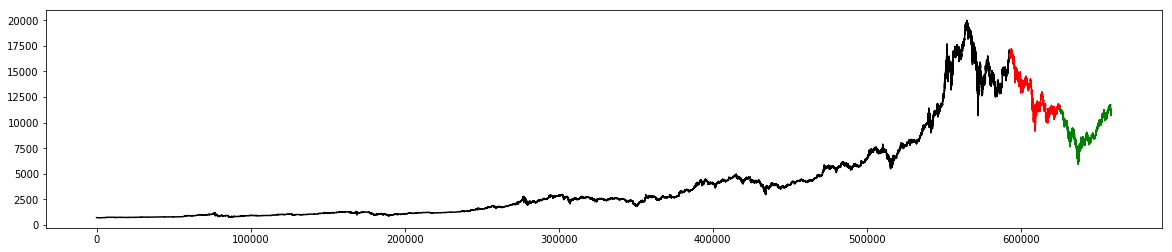

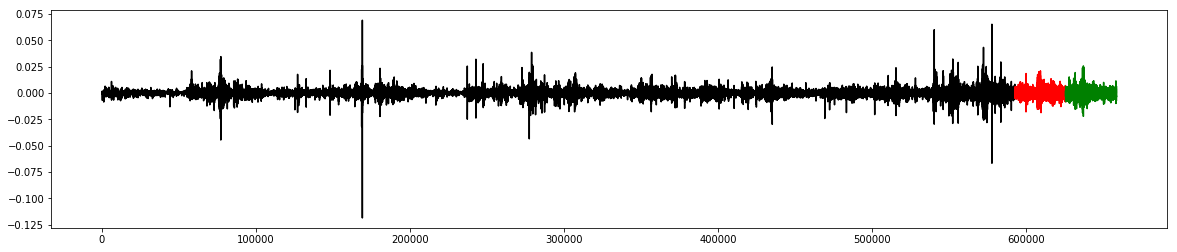

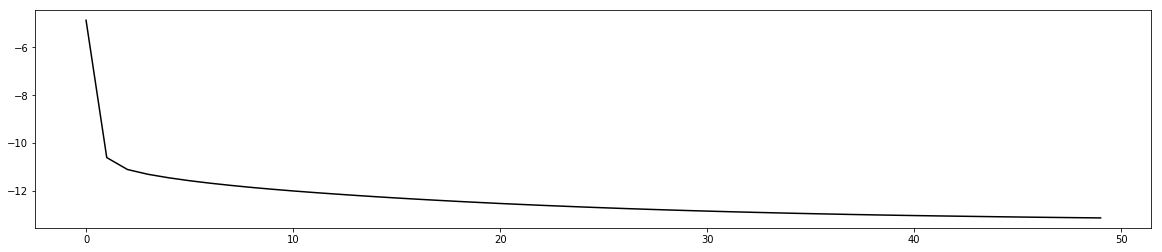

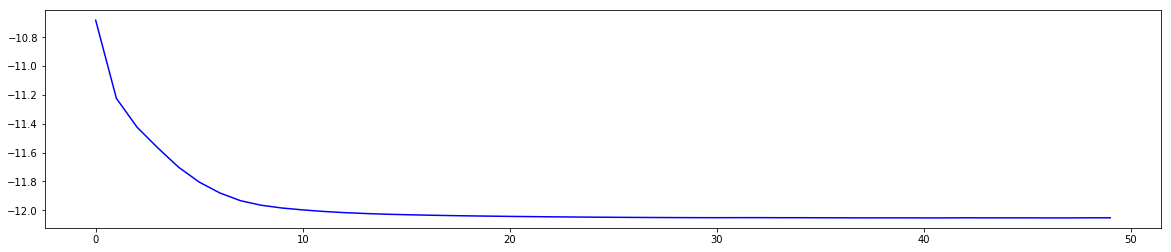

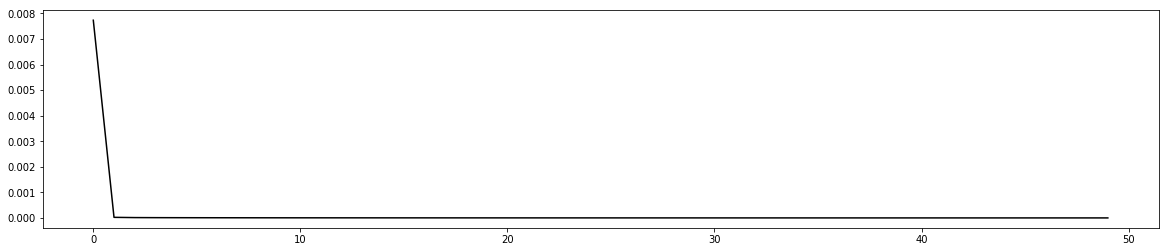

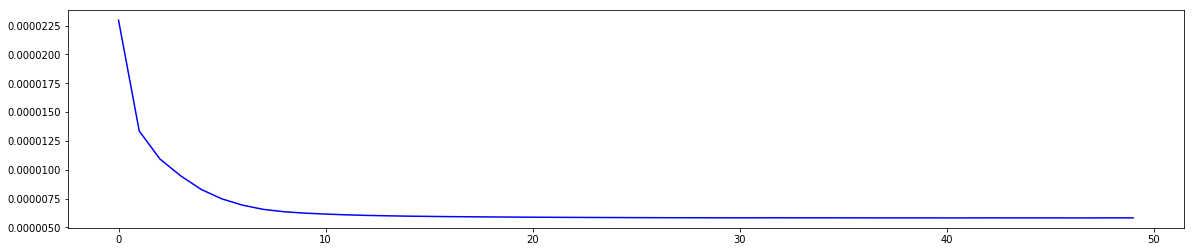

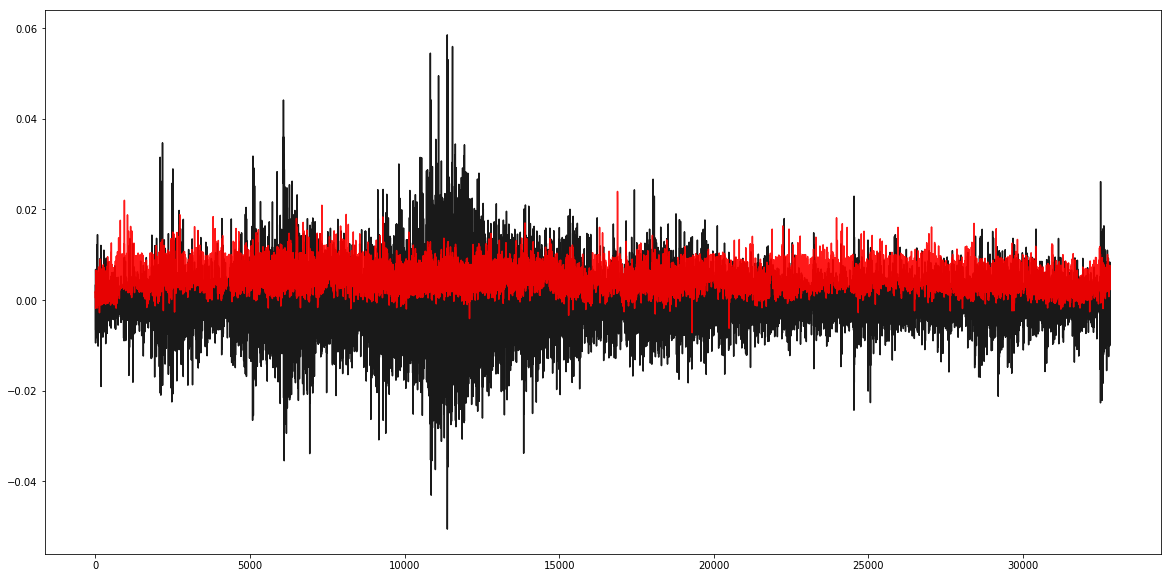

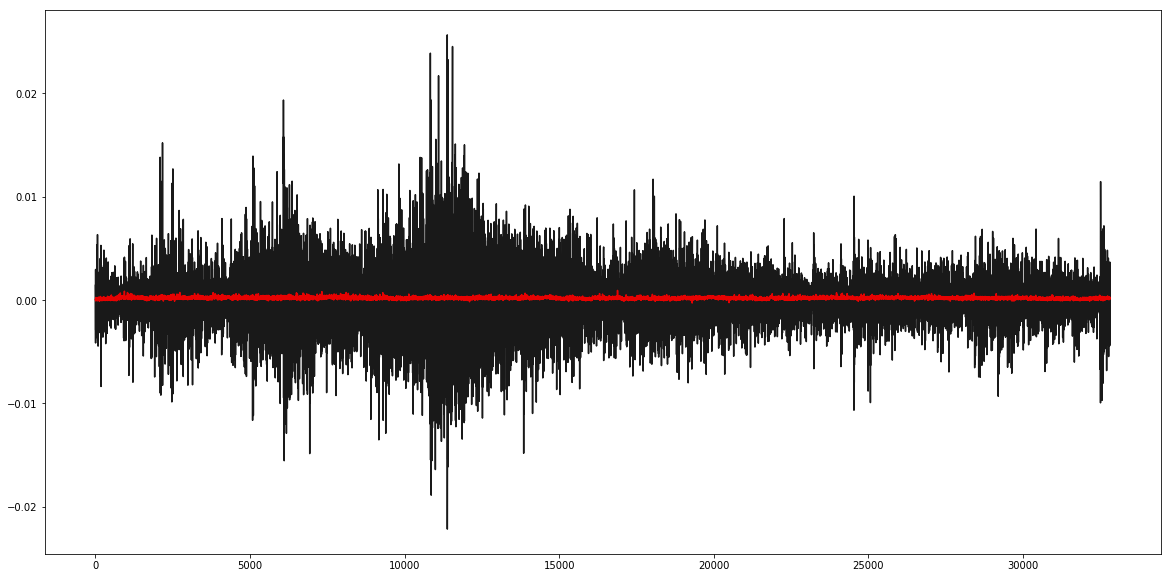

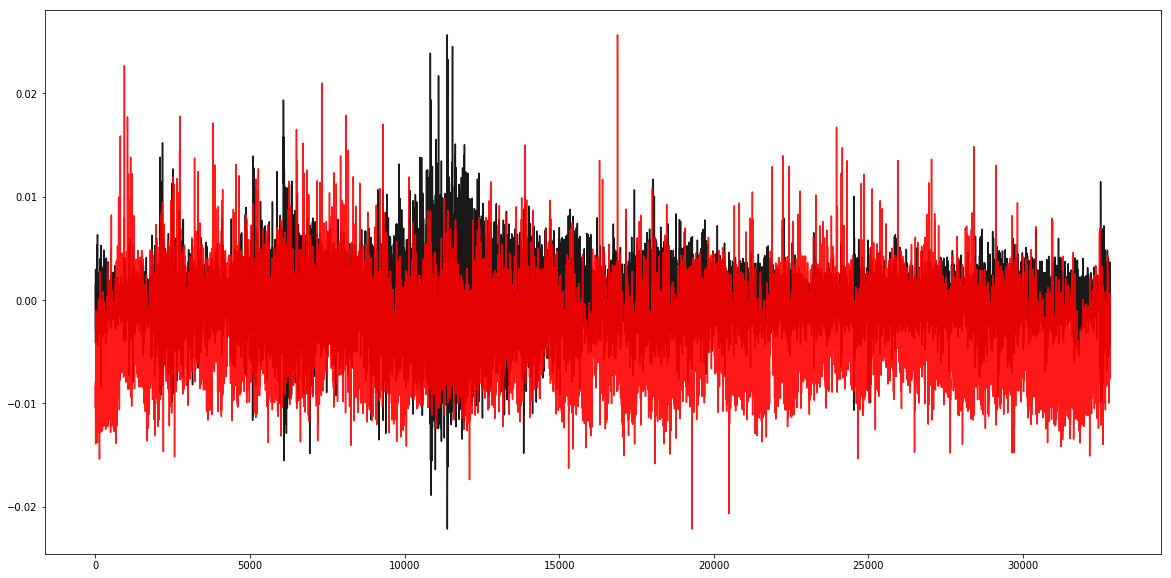

In [34]:
# EVALUATE MODEL
print('Evaluating...')
evaluate = evaluate_model(model, history, X_train, X_dev, X_test, Y_train, Y_dev, Y_test)

# Get test predictions
print('Getting test predictions...')
y_hat_test = model.predict(X_test)

# VISUALIZE
## Plot: 
# Historical price, color coded with train, dev, test
# Historical percent change, color coded with train, dev, test
# Train Loss, Dev Loss
# Actual price vs predicted price (or percent change) for test set
# Example features time series for one day (NOTE: in the preprocessing_final notebook)

timestep_within_window = 0
minute_start = 59
minute_end = len(Y_test)

print_save_events_props(Y_train.flatten(), Y_dev.flatten(), Y_test.flatten(), evaluate, model_name, model_path)
#print_save_events_props(Y_train, Y_dev, Y_test, evaluate, model_name, model_path)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')
plot_train_dev_losses(history)
plot_percent_change(y_hat_test, Y_test, timestep_within_window, minute_start, minute_end)

In [60]:
# y_pred = y_hat_test
# y_true = Y_test
# timestep_within_window=59
# ys=[]
# for i in range(len(y_pred)):
#     ys.append(y_pred[i][timestep_within_window])

# original_ys=[]
# for i in range(len(y_true)):
#     original_ys.append(y_true[i][timestep_within_window])

# ys_orig = np.array(original_ys)
# ys_pred = np.array(ys)


# OldRange = (ys_pred.max() - ys_pred.min())  
# NewRange = (ys_orig.max() - ys_orig.min())   
# new_ys_pred = (((ys - ys_pred.min()) * NewRange) / OldRange) + ys_orig.min()


# norm1 = ys_orig / np.linalg.norm(ys_orig)
# norm2 = ys_pred / np.linalg.norm(ys_pred)

# mse_test_norm = sum((norm2-norm1)**2)
# print(mse_test_norm)
# print(np.sqrt(mse_test_norm/len(norm2)))

# mse_test = sum((ys_pred-ys_orig)**2)
# print(mse_test)
# print(np.sqrt(mse_test/len(norm2)))

In [158]:
def mse(time_series):
    total_squared_error = 0
    total_absolute_error = 0
    prev_obv = time_series[0]
    for obv in time_series[1:]:
        total_squared_error += (obv - prev_obv)**2
        total_absolute_error += abs(obv - prev_obv)
        prev_obv = obv
    num_predictions = len(time_series) - 1
    mean_squared_error = total_squared_error / num_predictions
    mean_absolute_error = total_absolute_error / num_predictions
    root_mean_squared_error = np.sqrt(mean_squared_error)
    print('=== baseline ===')
    print('total squared error')
    print(total_squared_error)
    print('total absolute error')
    print(total_absolute_error)
    print('mean squared error')
    print(mean_squared_error)
    print('mean absolute error')
    print(mean_absolute_error) 
    print('root mean squared error')
    print(root_mean_squared_error) 
    print()
mse(X_train)

=== baseline ===
total squared error
[0.40823025]
total absolute error
[74.64538]
mean squared error
[1.2416895e-05]
mean absolute error
[0.00227044]
root mean squared error
[0.00352376]



In [33]:
##### MAIN MODEL #####

# HYPERPARAMETERS
window_size = 60
step = 1
predict_end_of_window = True

batch_size = 4096 #8192
num_epochs = 30
verbose = 1
loss = 'mean_squared_error'
optimizer = 'adam'
num_LSTM = 3
num_units = [128, 256, 256]
#num_LSTM = 2
#num_units = [256, 256]
dropout = 0.1

path = 'cboe/parquet_preprocessed_BTCUSD_merged'
day_start = 401
day_end = None

model_name = 'window-%s_step-%s_predEndWindow-%s_batch-%s_epochs-%s_loss-%s_opt-%s_numLSTMs-%s_numUnits-%s_dropout-%s_dayStart-%s_dayEnd-%s' % (window_size, step, str(predict_end_of_window), batch_size, num_epochs, 
                                                                                                                                                loss, optimizer, num_LSTM, num_units, dropout, str(day_start), str(day_end))
print(model_name+'\n')
model_path = 'models/%s' % model_name

# LOAD DATA
df = load_data(path, day_start, day_end)

# CREATE XY DATA
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = split(df)
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = create_all_XY(X_train, X_dev, X_test, Y_train, Y_dev, Y_test,
                                                               window_size, step, predict_end_of_window)

window-60_step-1_predEndWindow-True_batch-4096_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-[128, 256, 256]_dropout-0.1_dayStart-401_dayEnd-None

n_all:   658758
n_train: 592882
n_dev:   32938
n_test:  32938
(592882, 15)
(32938, 15)
(32938, 15)
(592882, 1)
(32938, 1)
(32938, 1)
Train, dev, test shapes:
(592823, 60, 15)
(32879, 60, 15)
(32879, 60, 15)
(592823, 1)
(32879, 1)
(32879, 1)


In [34]:
# INITIALIZE MODEL
model = initialize_model(X_train, loss, optimizer, num_LSTM, num_units, dropout, predict_end_of_window=predict_end_of_window)

# TRAIN MODEL
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, 
                    validation_data=(X_dev, Y_dev), verbose=verbose, shuffle=False) 

# SAVE MODEL AND HISTORY
save_model_history(model, history, model_path)

Train on 592823 samples, validate on 32879 samples
Epoch 1/30
592823/592823 [==============================] - 62s 104us/step - loss: 0.0017 - val_loss: 6.0902e-06
Epoch 2/30
592823/592823 [==============================] - 61s 103us/step - loss: 5.5060e-06 - val_loss: 5.8923e-06
Epoch 3/30
592823/592823 [==============================] - 61s 103us/step - loss: 4.8033e-06 - val_loss: 5.8638e-06
Epoch 4/30
592823/592823 [==============================] - 61s 103us/step - loss: 4.2548e-06 - val_loss: 5.8555e-06
Epoch 5/30
592823/592823 [==============================] - 61s 103us/step - loss: 3.8358e-06 - val_loss: 5.8557e-06
Epoch 6/30
592823/592823 [==============================] - 61s 103us/step - loss: 3.4894e-06 - val_loss: 5.8596e-06
Epoch 7/30
592823/592823 [==============================] - 61s 103us/step - loss: 3.2277e-06 - val_loss: 5.8406e-06
Epoch 8/30
592823/592823 [==============================] - 61s 103us/step - loss: 3.0083e-06 - val_loss: 5.8526e-06
Epoch 9/30
592823

In [39]:
# SAVE MODEL AND HISTORY
save_model_history(model, history, model_path)

Saved model and history to:
models/window-60_step-1_predEndWindow-True_batch-4096_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-401_dayEnd-None_20180321123940481133


In [49]:
# EVALUATE MODEL
print('Evaluating...')
evaluate = evaluate_model(model, history, X_train, X_dev, X_test, Y_train, Y_dev, Y_test, predict_end_of_window)

Evaluating...
Evaluating test loss...
Predicting y_hat_train...
Predicting y_hat_dev...
Predicting y_hat_test...


window-60_step-1_predEndWindow-True_batch-4096_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-401_dayEnd-None

========== EVENT COUNTS AND PROPORTIONS ==========
=== TRAIN ===
Down, Same, Up: [142066 299677 151080]
Down, Same, Up: [0.2396432  0.50550839 0.25484841]

=== DEV ===
Down, Same, Up: [15009  2432 15438]
Down, Same, Up: [0.45649199 0.07396819 0.46953983]

=== TEST ===
Down, Same, Up: [14867  2798 15214]
Down, Same, Up: [0.45217312 0.08509991 0.46272697]

========== CORRECTION DIRECTION PREDICTIONS ==========
TRAIN: 0.259297
DEV:   0.472642
TEST:  0.461936

========== FINAL LOSS ==========
TRAIN: 1.7994709404878375e-06
DEV:   5.791297482655252e-06
TEST:  1.7994709404878375e-06



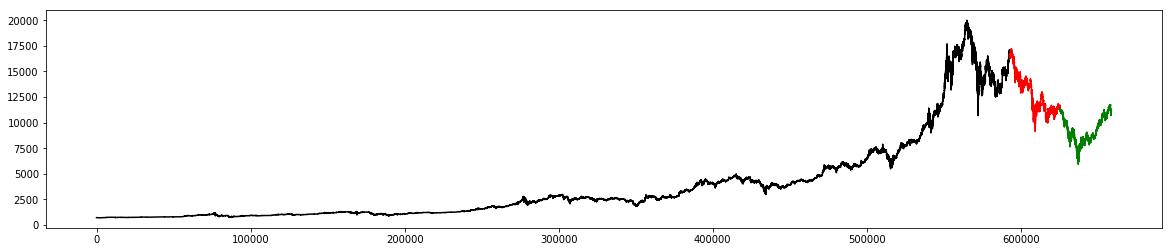

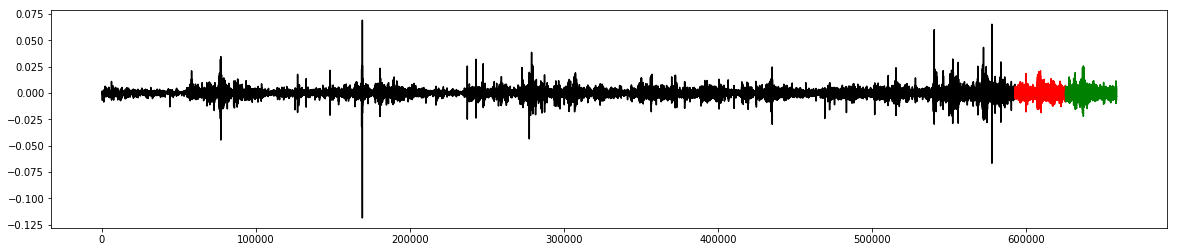

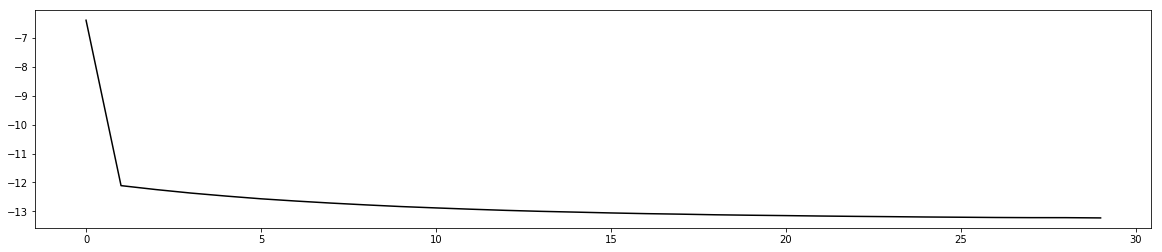

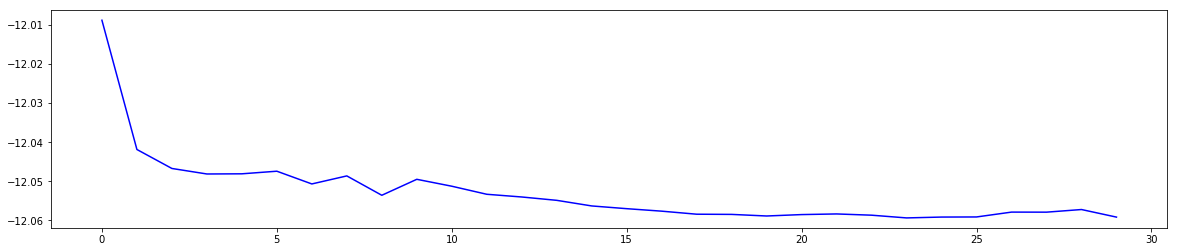

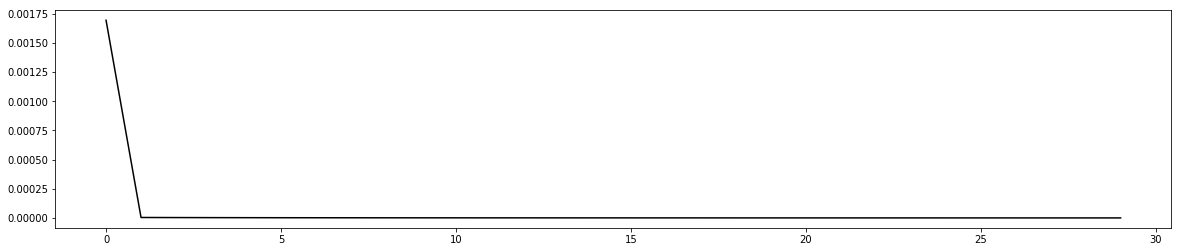

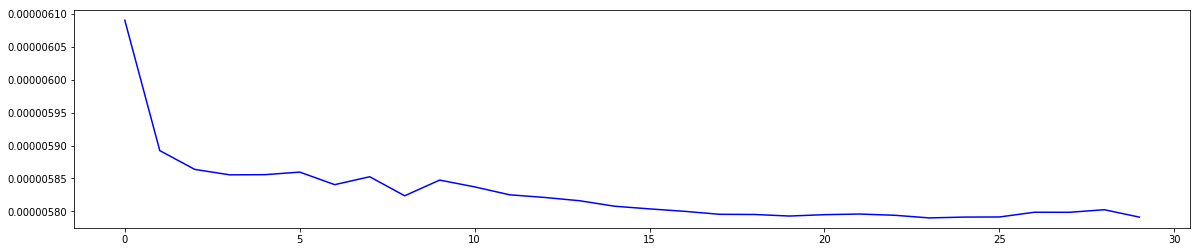

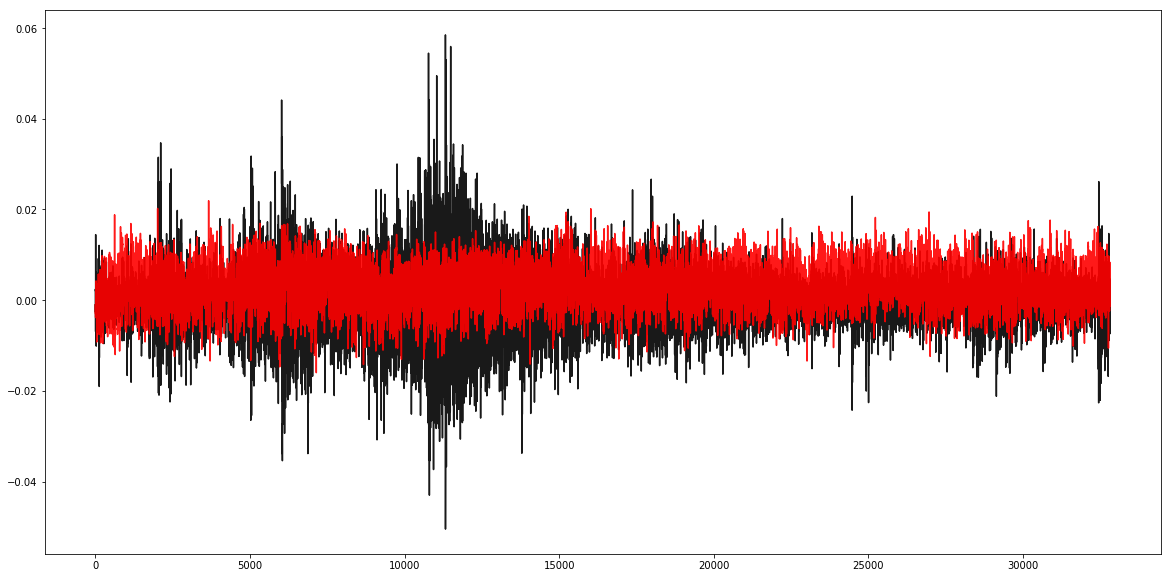

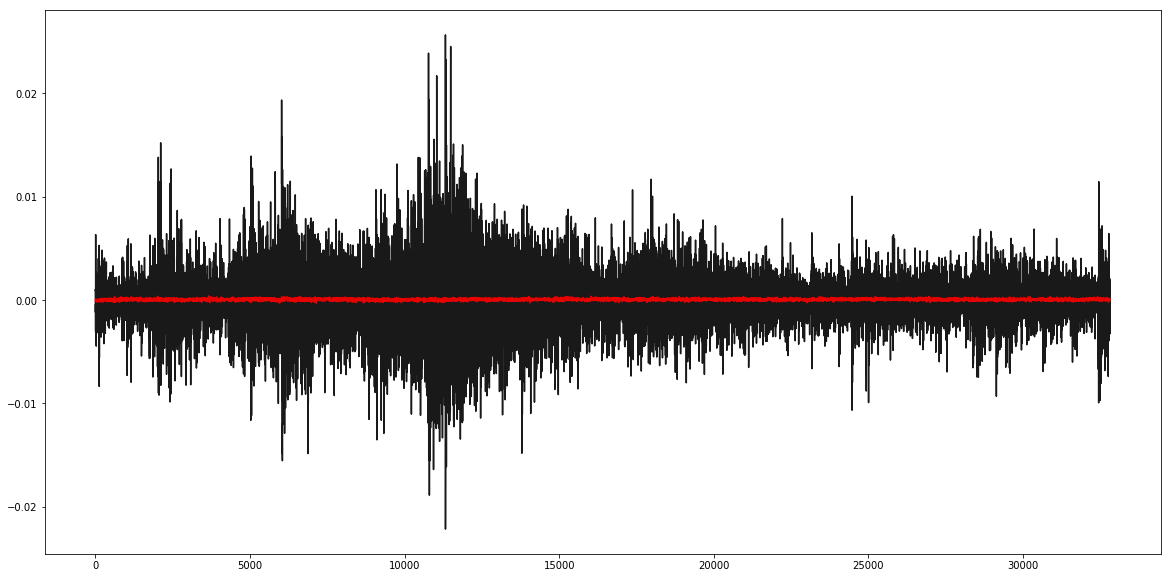

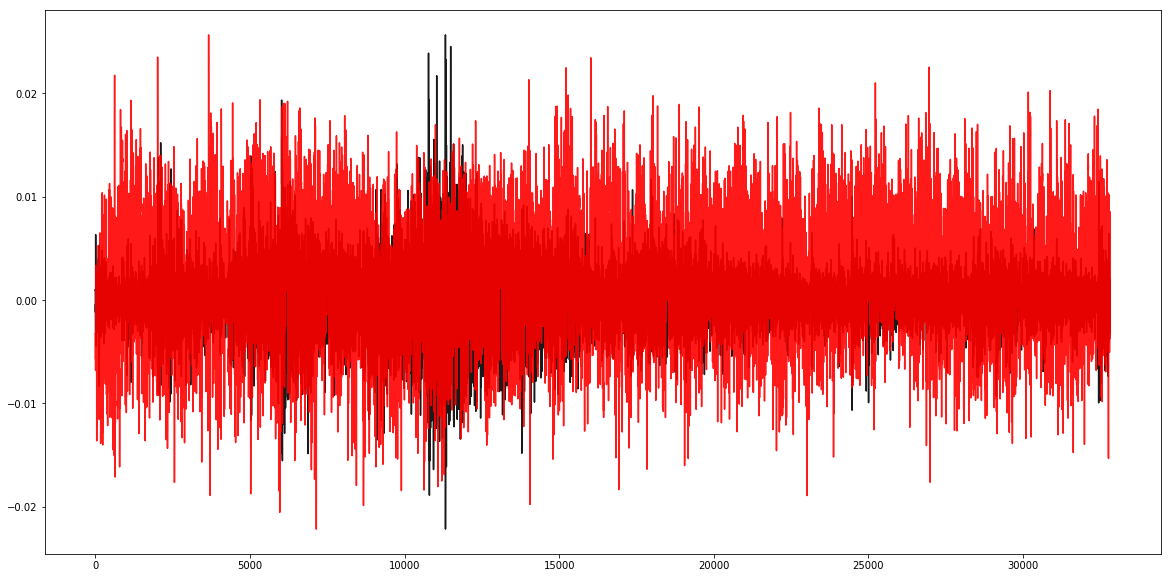

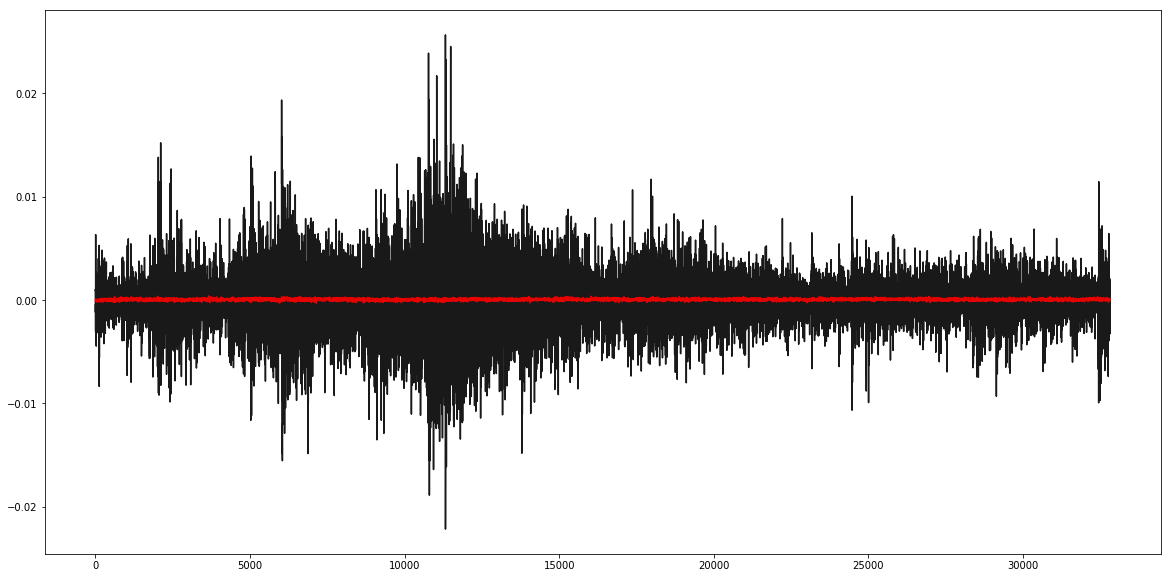

In [62]:
# VISUALIZE
## Plot: 
# Historical price, color coded with train, dev, test
# Historical percent change, color coded with train, dev, test
# Train Loss, Dev Loss
# Actual price vs predicted price (or percent change) for test set
# Example features time series for one day (NOTE: in the preprocessing_final notebook)

timestep_within_window = 0
minute_start = 59
minute_end = len(Y_test)

print_save_events_props(Y_train.flatten(), Y_dev.flatten(), Y_test.flatten(), evaluate, model_name, model_path)
#print_save_events_props(Y_train, Y_dev, Y_test, evaluate, model_name, model_path)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')
plot_train_dev_losses(history)
plot_percent_change(evaluate['y_hat_test'], Y_test, timestep_within_window, minute_start, minute_end, predict_end_of_window)

In [35]:
##### MAIN MODEL #####

# HYPERPARAMETERS
window_size = 60
step = 1
predict_end_of_window = True
temporal_features = True

batch_size = 4096 #8192
num_epochs = 30
verbose = 1
loss = 'mean_squared_error'
optimizer = 'adam'
num_LSTM = 3
num_units = [128, 256, 256]
#num_LSTM = 2
#num_units = [256, 256]
dropout = 0.1

path = 'cboe/parquet_preprocessed_BTCUSD_merged'
day_start = 401
day_end = None

model_name = 'window-%s_step-%s_predEndWindow-%s_temporalFeat-%s_batch-%s_epochs-%s_loss-%s_opt-%s_numLSTMs-%s_numUnits-%s_dropout-%s_dayStart-%s_dayEnd-%s' % (window_size, step, str(predict_end_of_window), str(temporal_features), batch_size, num_epochs, loss, optimizer, num_LSTM, num_units, dropout, str(day_start), str(day_end))
print(model_name+'\n')
model_path = 'models/%s' % model_name

# LOAD DATA
df = load_data(path, day_start, day_end)

# CREATE XY DATA
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = split(df, temporal_features)
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = create_all_XY(X_train, X_dev, X_test, Y_train, Y_dev, Y_test,
                                                               window_size, step, predict_end_of_window)

window-60_step-1_predEndWindow-True_temporalFeat-True_batch-4096_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-[128, 256, 256]_dropout-0.1_dayStart-401_dayEnd-None

n_all:   658758
n_train: 592882
n_dev:   32938
n_test:  32938
(592882, 58)
(32938, 58)
(32938, 58)
(592882, 1)
(32938, 1)
(32938, 1)
Train, dev, test shapes:
(592823, 60, 58)
(32879, 60, 58)
(32879, 60, 58)
(592823, 1)
(32879, 1)
(32879, 1)


In [36]:
# INITIALIZE MODEL
model = initialize_model(X_train, loss, optimizer, num_LSTM, num_units, dropout, predict_end_of_window=predict_end_of_window)

# TRAIN MODEL
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, 
                    validation_data=(X_dev, Y_dev), verbose=verbose, shuffle=False) 

# SAVE MODEL AND HISTORY
save_model_history(model, history, model_path)

Train on 592823 samples, validate on 32879 samples
Epoch 1/30
592823/592823 [==============================] - 66s 111us/step - loss: 0.0025 - val_loss: 9.0885e-05
Epoch 2/30
592823/592823 [==============================] - 64s 109us/step - loss: 7.7036e-05 - val_loss: 7.4930e-06
Epoch 3/30
592823/592823 [==============================] - 64s 109us/step - loss: 2.1967e-05 - val_loss: 7.0570e-06
Epoch 4/30
592823/592823 [==============================] - 64s 109us/step - loss: 2.4028e-05 - val_loss: 7.0483e-06
Epoch 5/30
592823/592823 [==============================] - 64s 109us/step - loss: 2.3910e-05 - val_loss: 6.9112e-06
Epoch 6/30
592823/592823 [==============================] - 64s 109us/step - loss: 1.6706e-05 - val_loss: 6.3367e-06
Epoch 7/30
592823/592823 [==============================] - 64s 109us/step - loss: 9.7070e-06 - val_loss: 6.1447e-06
Epoch 8/30
592823/592823 [==============================] - 64s 109us/step - loss: 6.8732e-06 - val_loss: 6.2294e-06
Epoch 9/30
592823

In [37]:
# EVALUATE MODEL
print('Evaluating...')
evaluate = evaluate_model(model, history, X_train, X_dev, X_test, Y_train, Y_dev, Y_test, predict_end_of_window)

Evaluating...
Evaluating test loss...
Predicting y_hat_train...
Predicting y_hat_dev...
Predicting y_hat_test...


window-60_step-1_predEndWindow-True_temporalFeat-True_batch-4096_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-[128, 256, 256]_dropout-0.1_dayStart-401_dayEnd-None

========== EVENT COUNTS AND PROPORTIONS ==========
=== TRAIN ===
Down, Same, Up: [142066 299677 151080]
Down, Same, Up: [0.2396432  0.50550839 0.25484841]

=== DEV ===
Down, Same, Up: [15009  2432 15438]
Down, Same, Up: [0.45649199 0.07396819 0.46953983]

=== TEST ===
Down, Same, Up: [14867  2798 15214]
Down, Same, Up: [0.45217312 0.08509991 0.46272697]

========== CORRECTION DIRECTION PREDICTIONS ==========
TRAIN: 0.251613
DEV:   0.458682
TEST:  0.460659

========== FINAL LOSS ==========
TRAIN: 1.718410974768474e-05
DEV:   6.934173198808668e-06
TEST:  1.718410974768474e-05



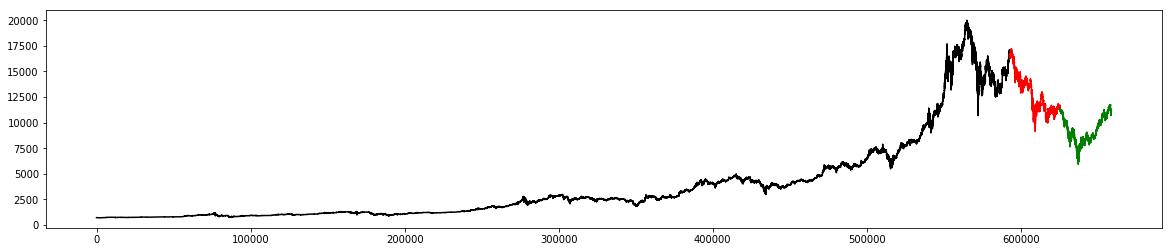

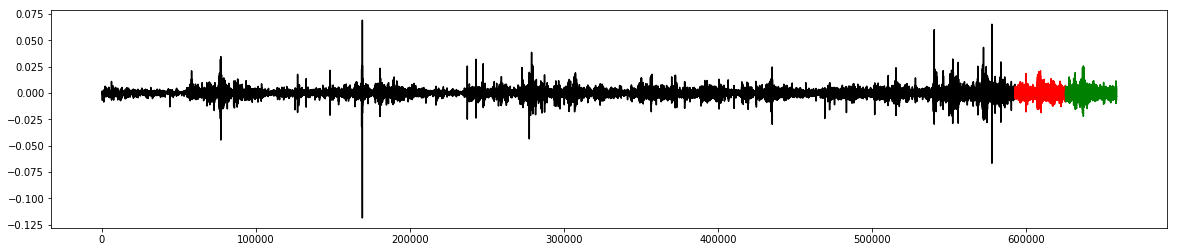

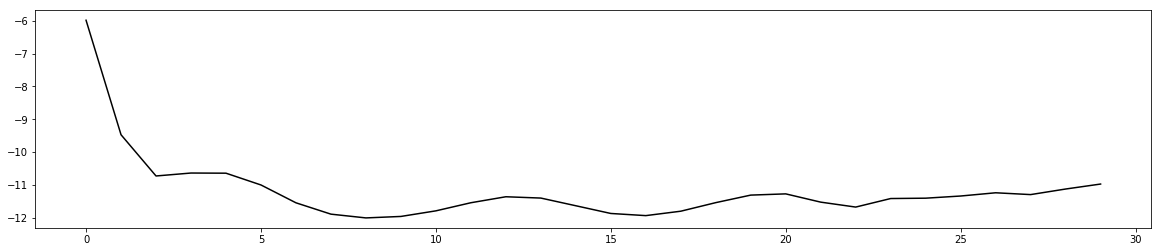

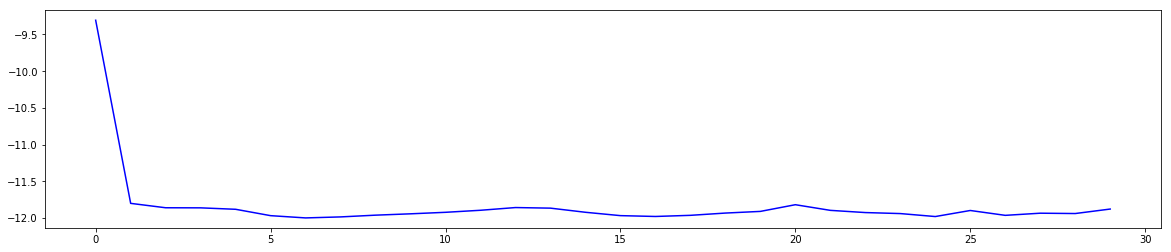

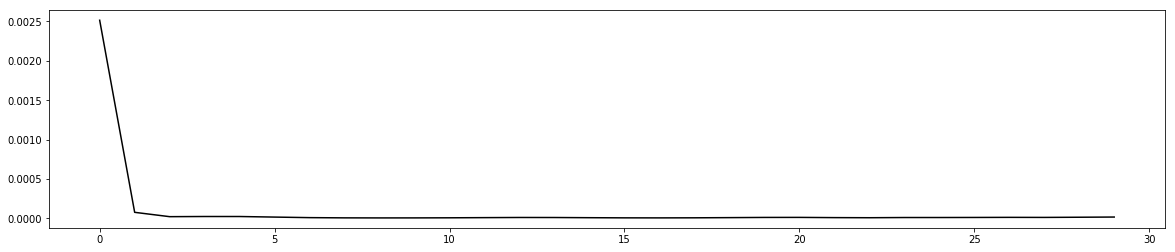

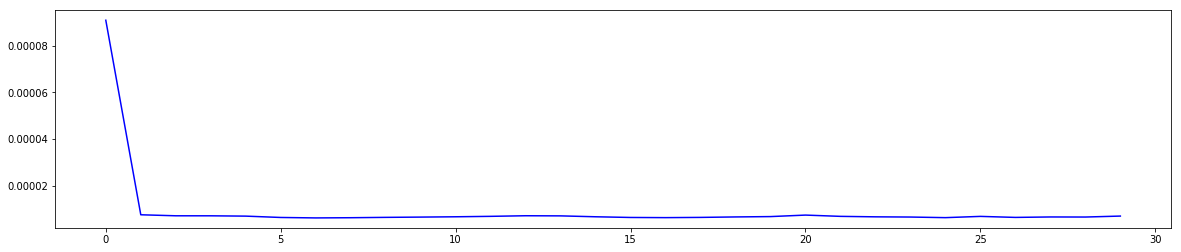

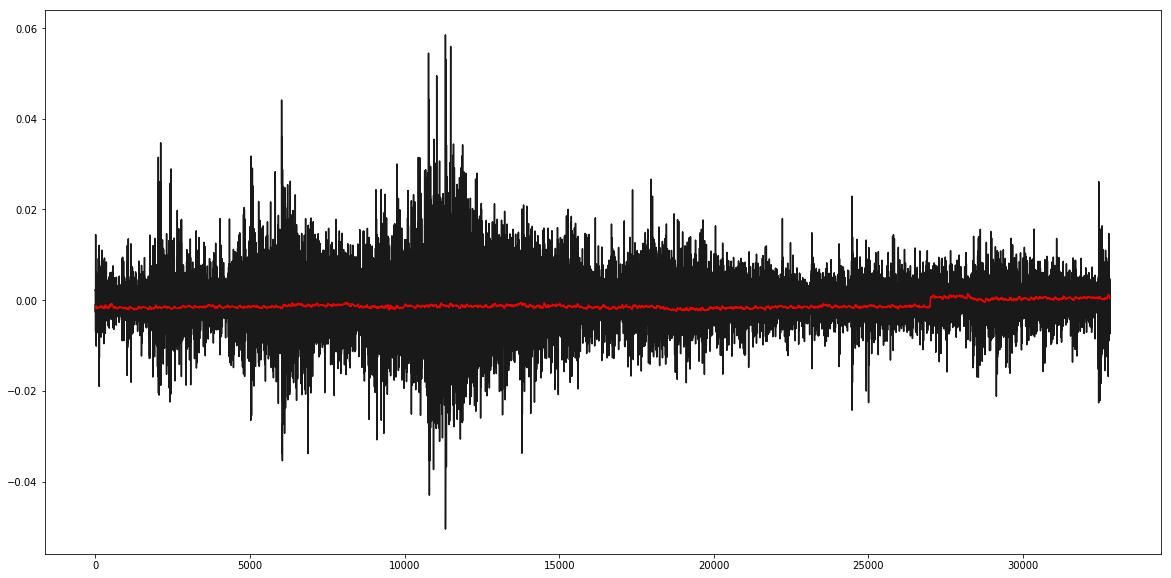

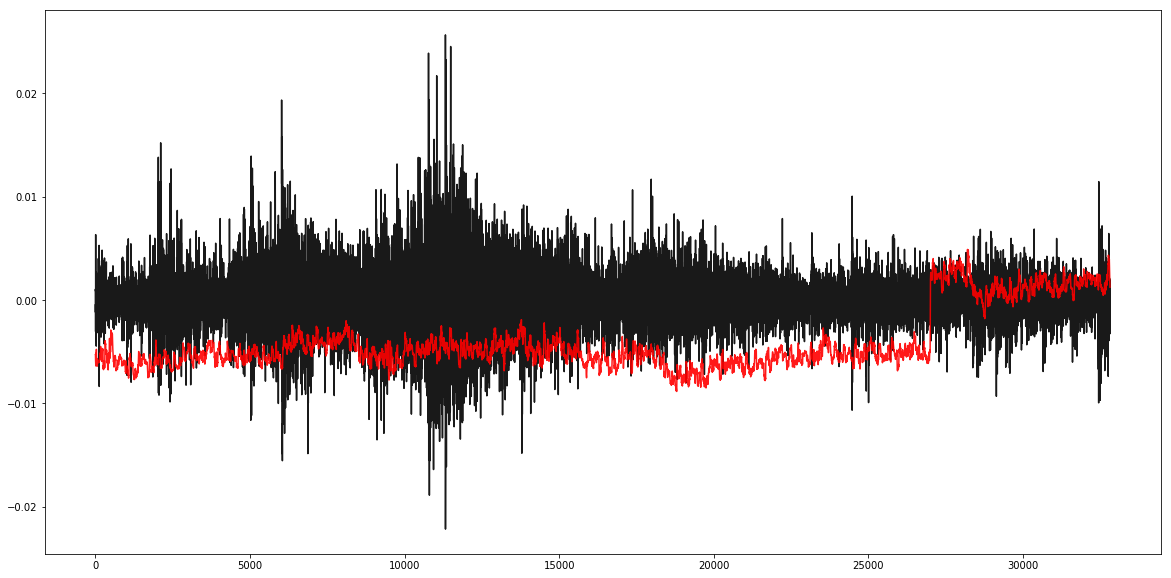

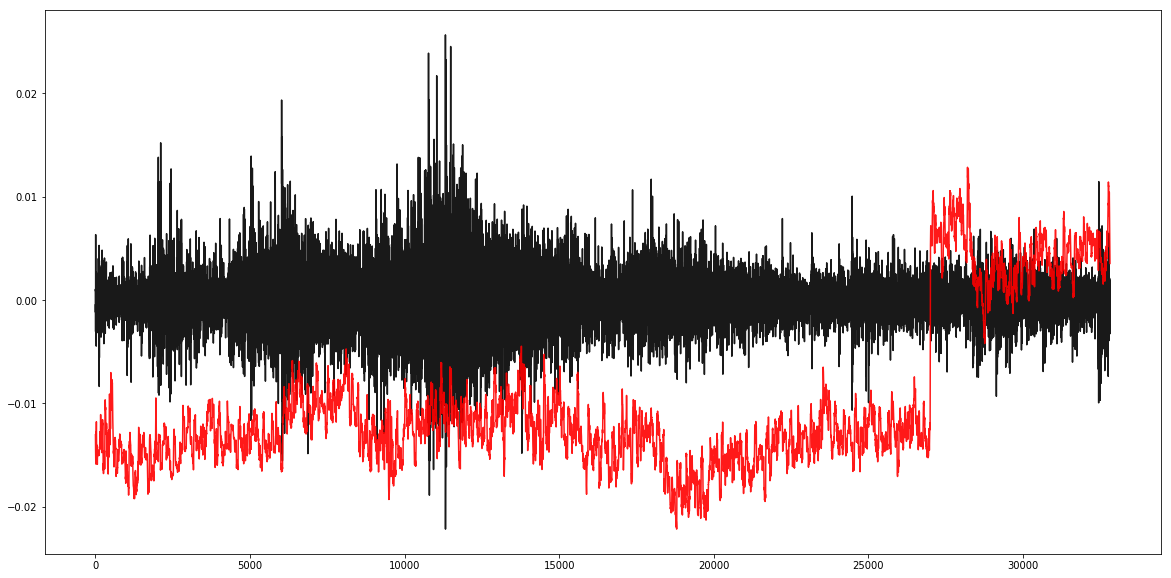

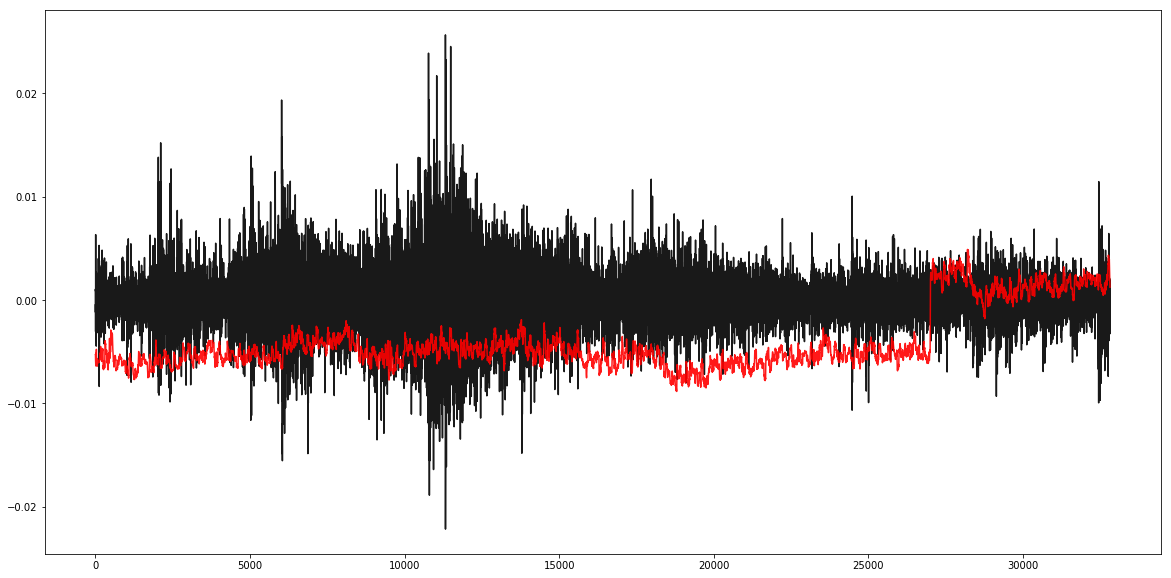

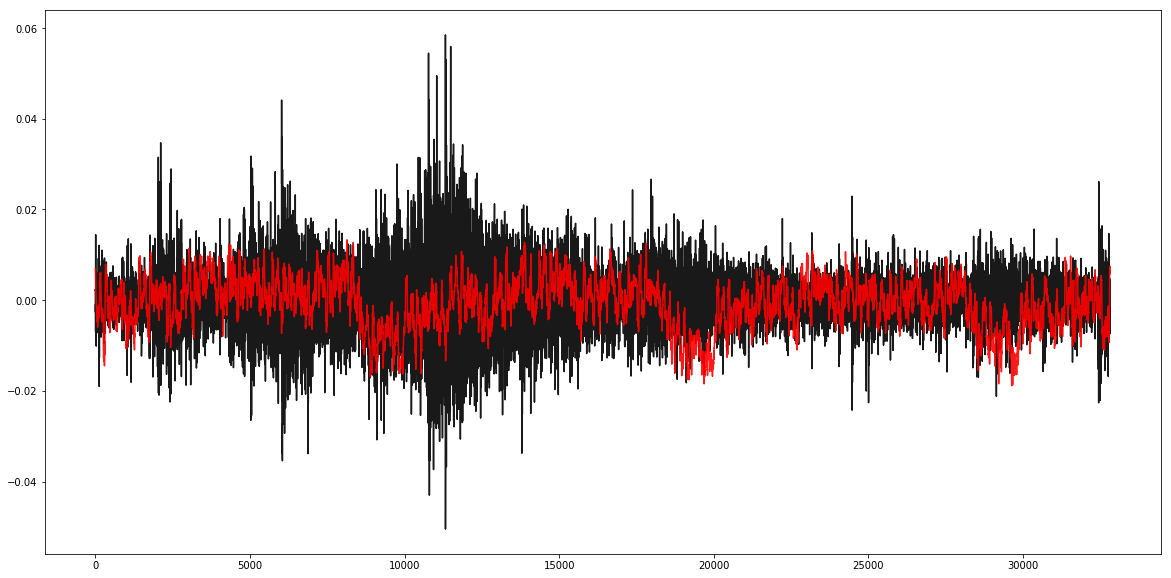

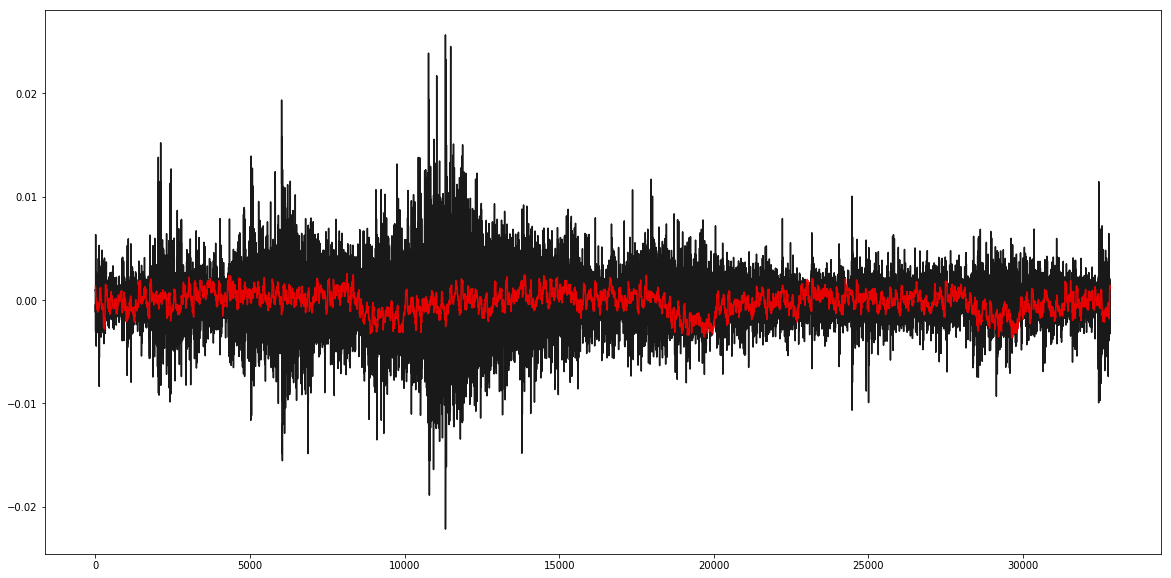

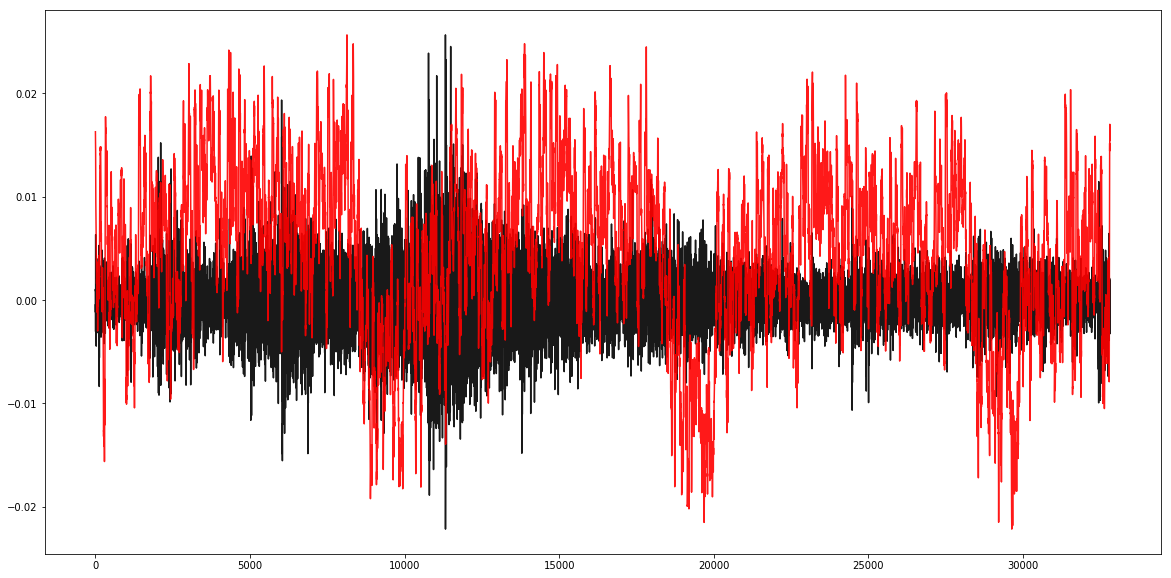

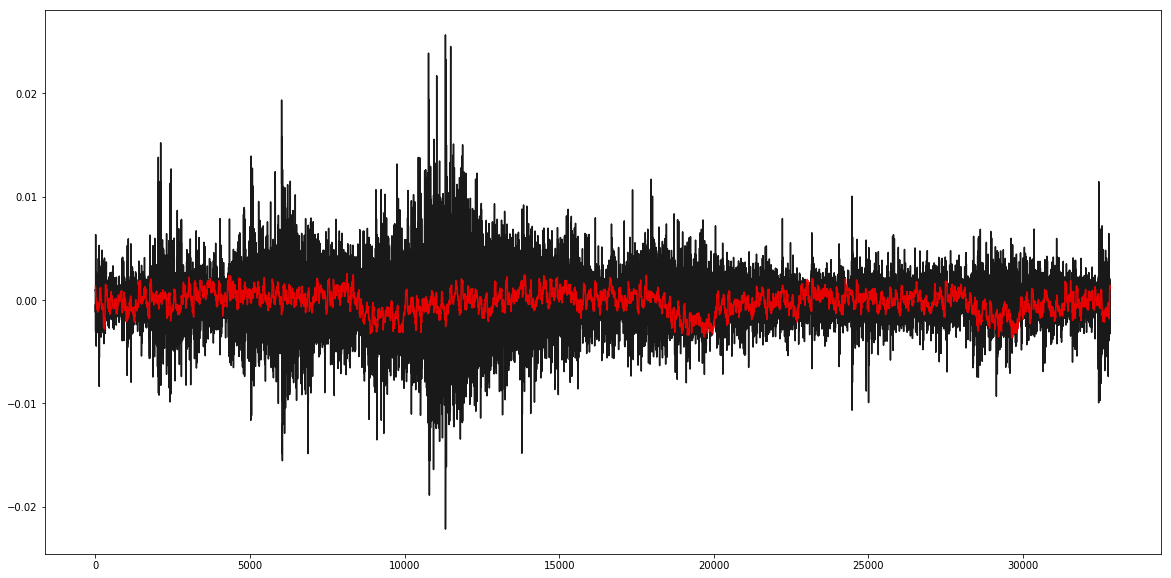

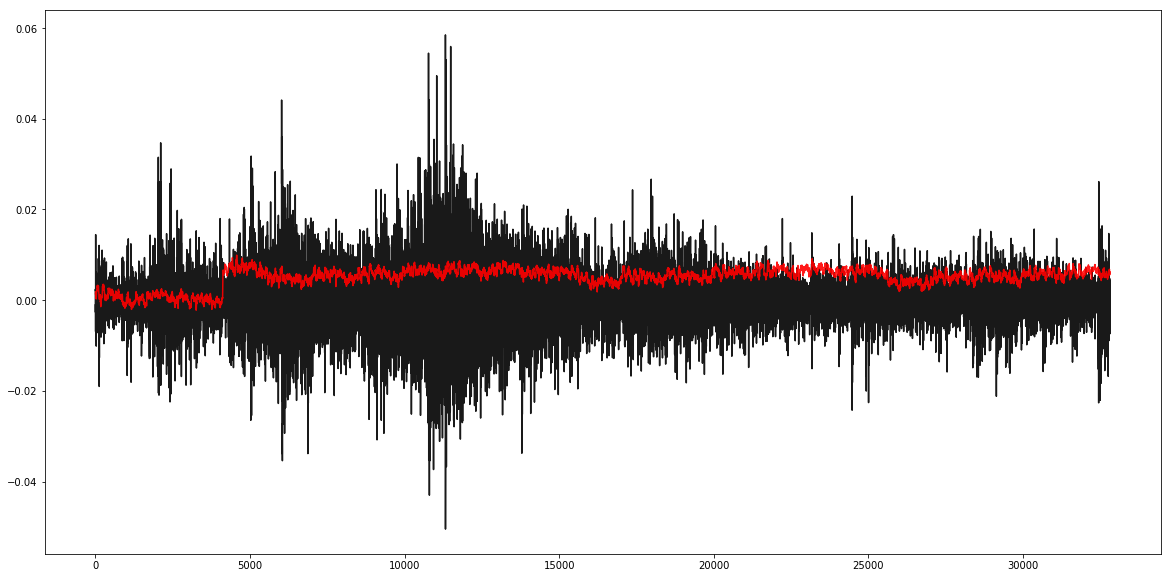

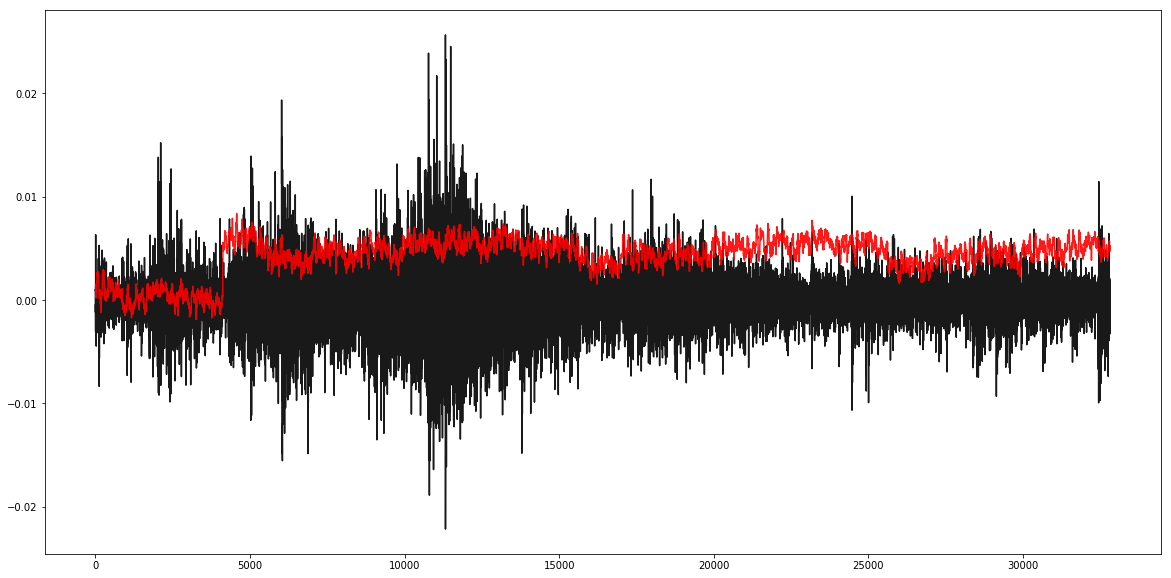

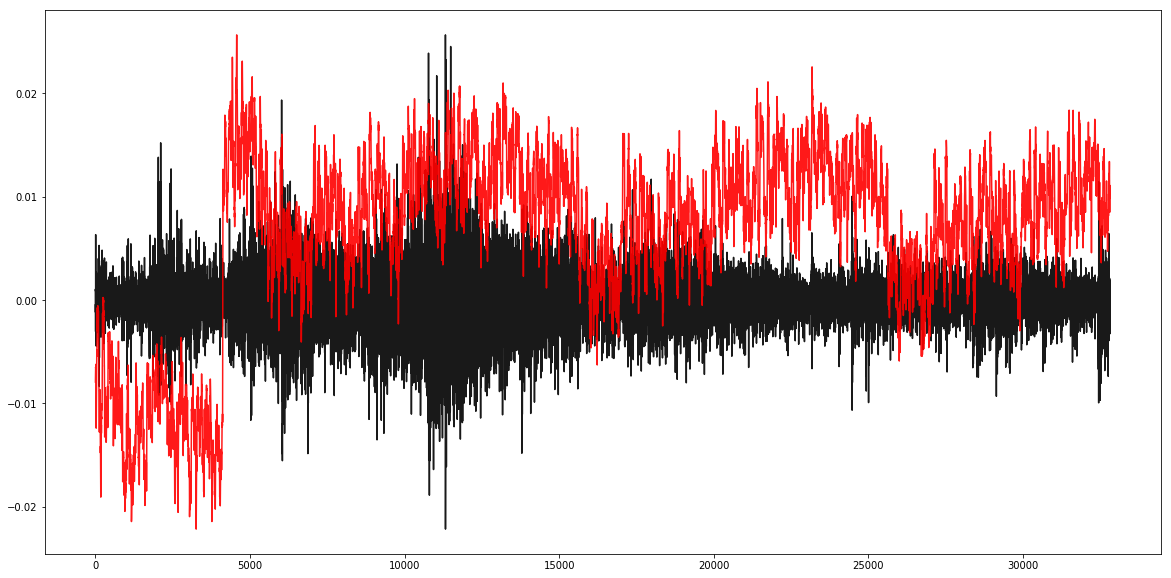

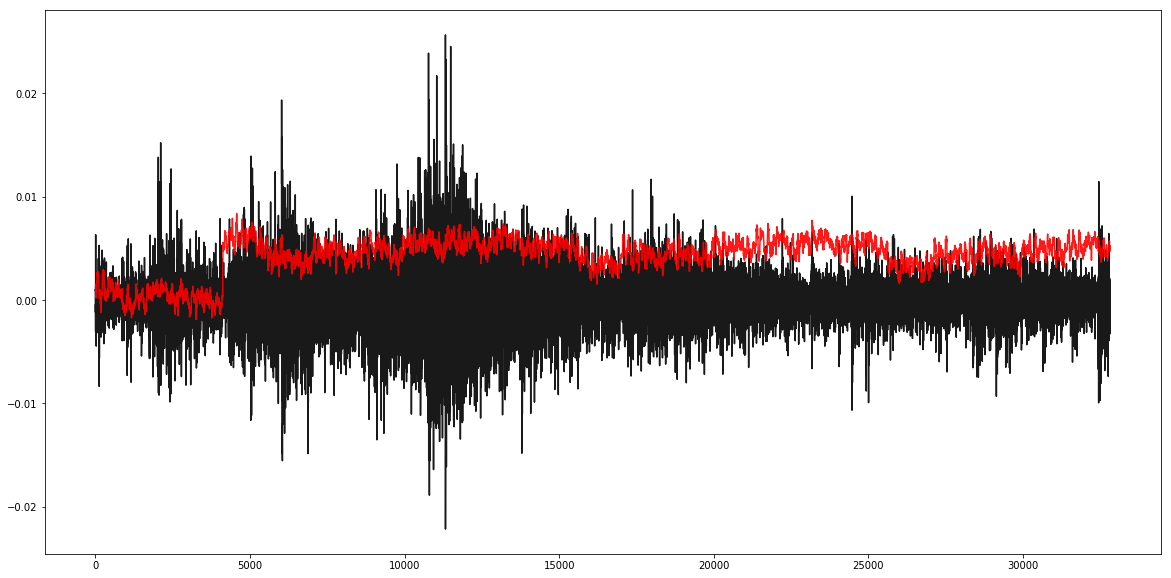

In [38]:
# VISUALIZE
## Plot: 
# Historical price, color coded with train, dev, test
# Historical percent change, color coded with train, dev, test
# Train Loss, Dev Loss
# Actual price vs predicted price (or percent change) for test set
# Example features time series for one day (NOTE: in the preprocessing_final notebook)

timestep_within_window = 0
minute_start = 59
minute_end = len(Y_test)

print_save_events_props(Y_train.flatten(), Y_dev.flatten(), Y_test.flatten(), evaluate, model_name, model_path)
#print_save_events_props(Y_train, Y_dev, Y_test, evaluate, model_name, model_path)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')
plot_train_dev_losses(history)
plot_percent_change(evaluate['y_hat_train'], Y_test, timestep_within_window, minute_start, minute_end, predict_end_of_window)
plot_percent_change(evaluate['y_hat_dev'], Y_test, timestep_within_window, minute_start, minute_end, predict_end_of_window)
plot_percent_change(evaluate['y_hat_test'], Y_test, timestep_within_window, minute_start, minute_end, predict_end_of_window)

In [30]:
##### MAIN MODEL #####

# HYPERPARAMETERS
window_size = 60
step = 1
predict_end_of_window = False
temporal_features = True

batch_size = 4096 #8192
num_epochs = 30
verbose = 1
loss = 'mean_squared_error'
optimizer = 'adam'
num_LSTM = 3
num_units = [128, 256, 256]
#num_LSTM = 2
#num_units = [256, 256]
dropout = 0.1

path = 'cboe/parquet_preprocessed_BTCUSD_merged'
day_start = 401
day_end = None

num_units_string = '-'.join([str(u) for u in num_units])

model_name = 'window-%s_step-%s_predEndWindow-%s_temporalFeat-%s_batch-%s_epochs-%s_loss-%s_opt-%s_numLSTMs-%s_numUnits-%s_dropout-%s_dayStart-%s_dayEnd-%s' % (window_size, step, str(predict_end_of_window), str(temporal_features), batch_size, num_epochs, loss, optimizer, num_LSTM, num_units_string, dropout, str(day_start), str(day_end))
print(model_name+'\n')
model_path = 'models/%s' % model_name  

# LOAD DATA
df = load_data(path, day_start, day_end)

# CREATE XY DATA
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = split(df, temporal_features)
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = create_all_XY(X_train, X_dev, X_test, Y_train, Y_dev, Y_test,
                                                               window_size, step, predict_end_of_window)

window-60_step-1_predEndWindow-False_temporalFeat-True_batch-4096_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-401_dayEnd-None

n_all:   658758
n_train: 592882
n_dev:   32938
n_test:  32938
(592882, 58)
(32938, 58)
(32938, 58)
(592882, 1)
(32938, 1)
(32938, 1)
Train, dev, test shapes:
(592823, 60, 58)
(32879, 60, 58)
(32879, 60, 58)
(592823, 60, 1)
(32879, 60, 1)
(32879, 60, 1)


In [31]:
# INITIALIZE MODEL
model = initialize_model(X_train, loss, optimizer, num_LSTM, num_units, dropout, predict_end_of_window=predict_end_of_window)

# TRAIN MODEL
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, 
                    validation_data=(X_dev, Y_dev), verbose=verbose, shuffle=False) 

# SAVE MODEL AND HISTORY
save_model_history(model, history, model_path)

Train on 592823 samples, validate on 32879 samples
Epoch 1/30
592823/592823 [==============================] - 67s 112us/step - loss: 0.0013 - val_loss: 5.2391e-05
Epoch 2/30
592823/592823 [==============================] - 65s 110us/step - loss: 2.8545e-05 - val_loss: 1.7100e-05
Epoch 3/30
592823/592823 [==============================] - 65s 110us/step - loss: 9.8155e-06 - val_loss: 6.8738e-06
Epoch 4/30
592823/592823 [==============================] - 65s 110us/step - loss: 9.3400e-06 - val_loss: 7.6335e-06
Epoch 5/30
592823/592823 [==============================] - 65s 110us/step - loss: 9.4583e-06 - val_loss: 6.0944e-06
Epoch 6/30
592823/592823 [==============================] - 65s 110us/step - loss: 9.7990e-06 - val_loss: 6.5086e-06
Epoch 7/30
592823/592823 [==============================] - 65s 110us/step - loss: 9.9822e-06 - val_loss: 6.2617e-06
Epoch 8/30
592823/592823 [==============================] - 65s 110us/step - loss: 1.1582e-05 - val_loss: 6.4821e-06
Epoch 9/30
592823

In [32]:
# EVALUATE MODEL
print('Evaluating...')
evaluate = evaluate_model(model, history, X_train, X_dev, X_test, Y_train, Y_dev, Y_test, predict_end_of_window)

Evaluating...
Evaluating test loss...
Predicting y_hat_train...
Predicting y_hat_dev...
Predicting y_hat_test...


window-60_step-1_predEndWindow-False_temporalFeat-True_batch-4096_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-401_dayEnd-None

========== EVENT COUNTS AND PROPORTIONS ==========
=== TRAIN ===
Down, Same, Up: [ 8523087 17982274  9064019]
Down, Same, Up: [0.23961866 0.50555489 0.25482645]

=== DEV ===
Down, Same, Up: [900438 145770 926532]
Down, Same, Up: [0.45644028 0.07389215 0.46966757]

=== TEST ===
Down, Same, Up: [891647 168413 912680]
Down, Same, Up: [0.45198404 0.08537009 0.46264586]

========== CORRECTION DIRECTION PREDICTIONS ==========
TRAIN: 0.243837
DEV:   0.460592
TEST:  0.458735

========== FINAL LOSS ==========
TRAIN: 4.959991545332069e-06
DEV:   5.909525290337497e-06
TEST:  5.97258021087912e-06



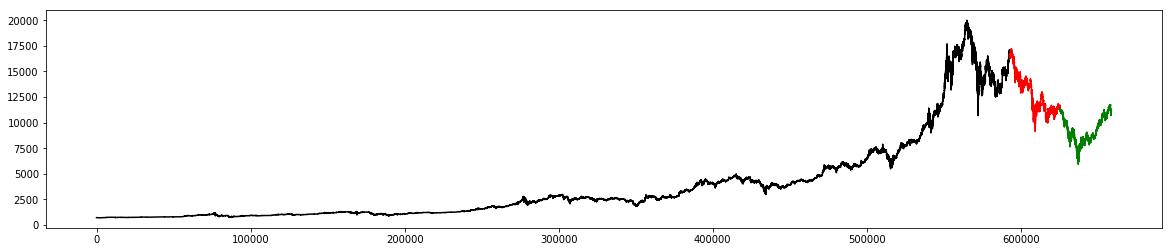

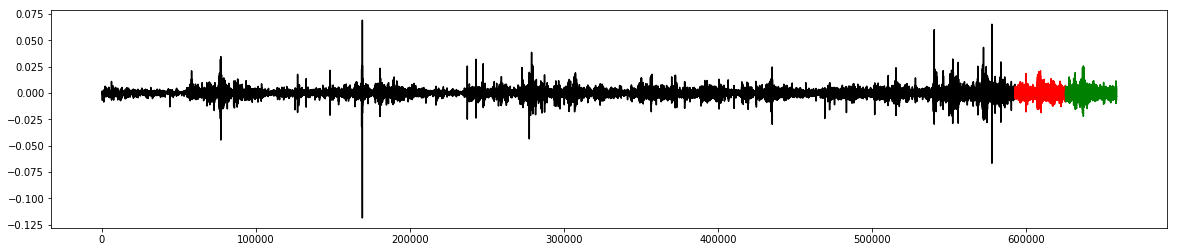

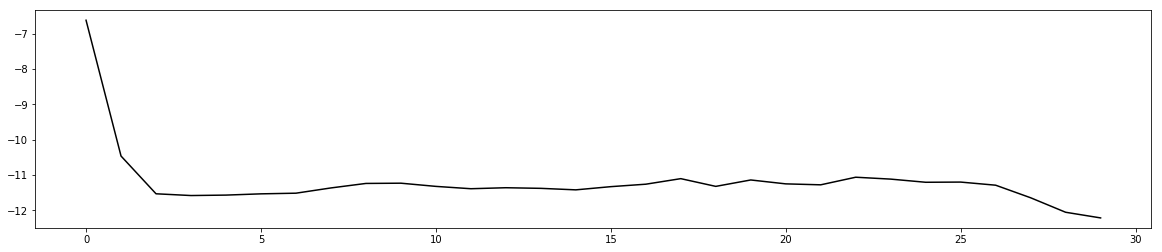

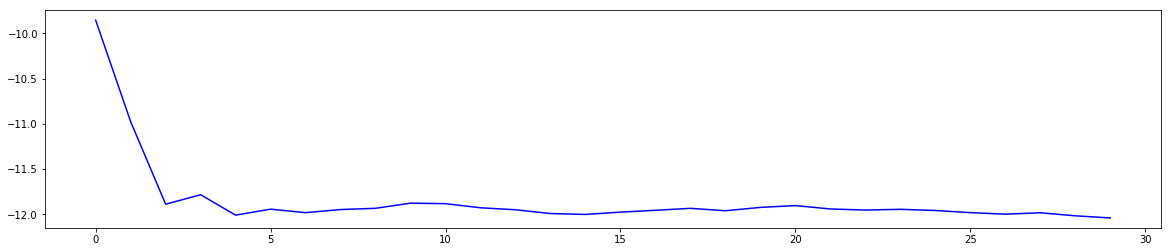

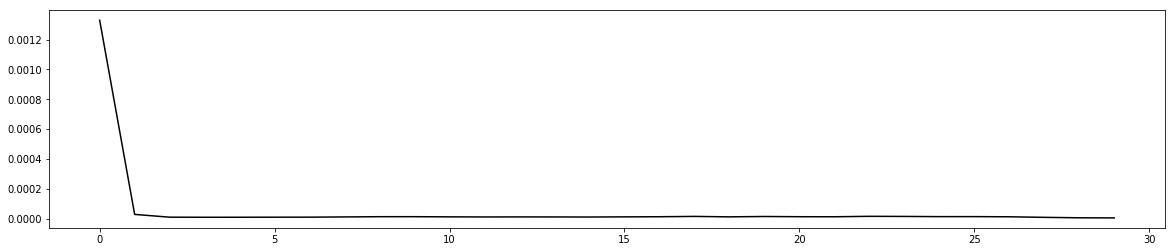

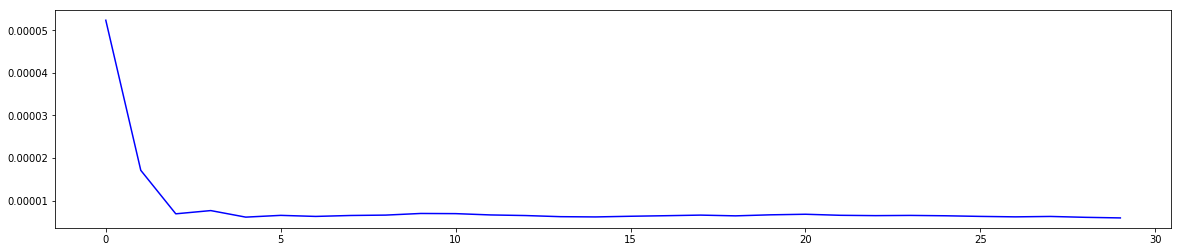

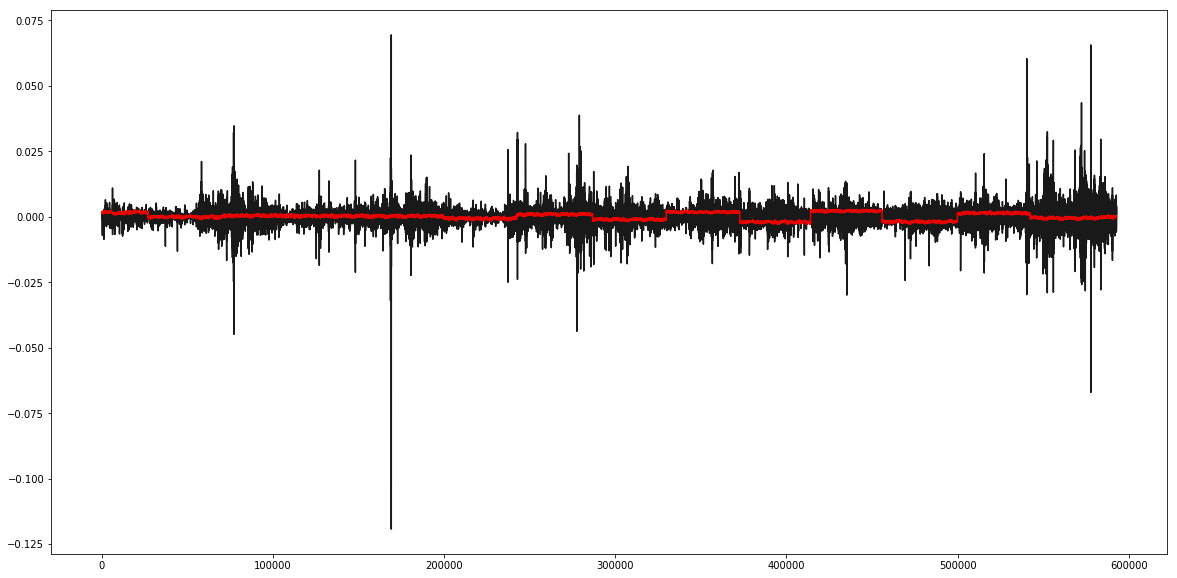

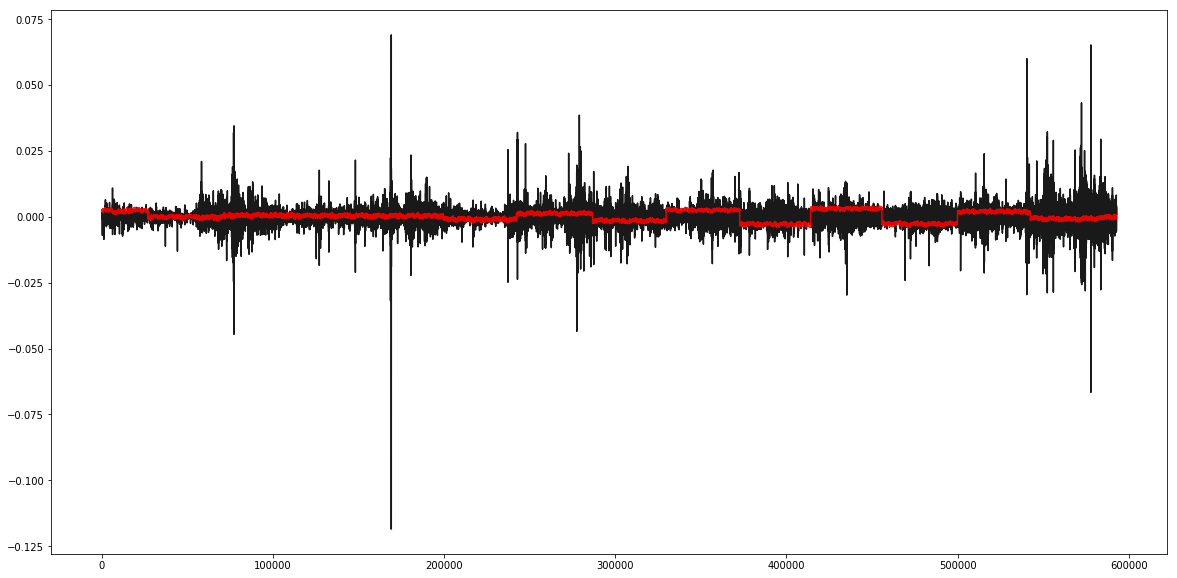

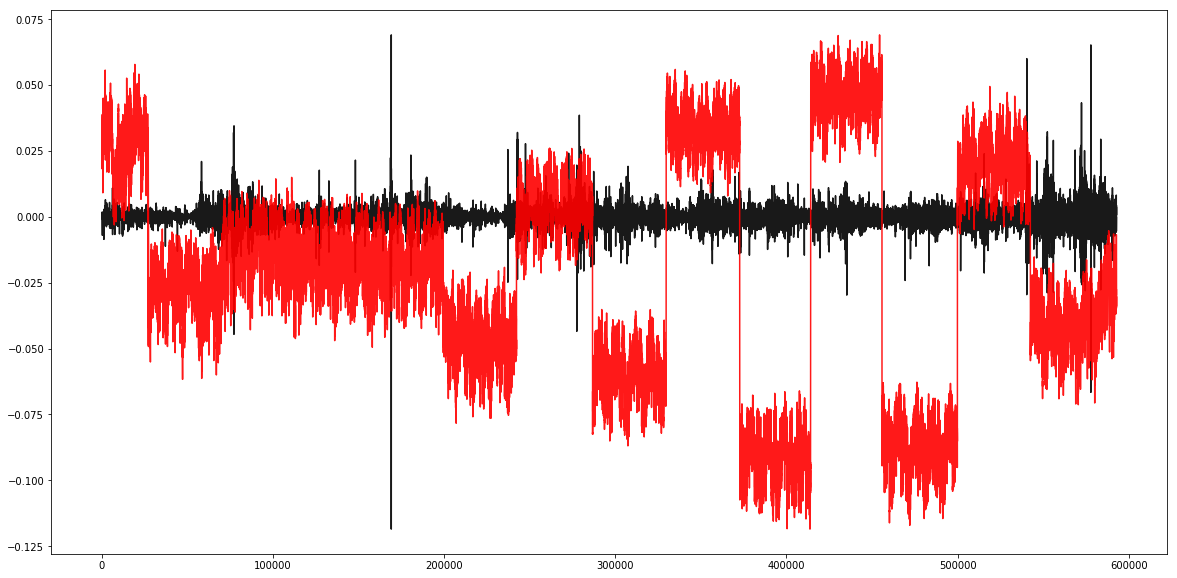

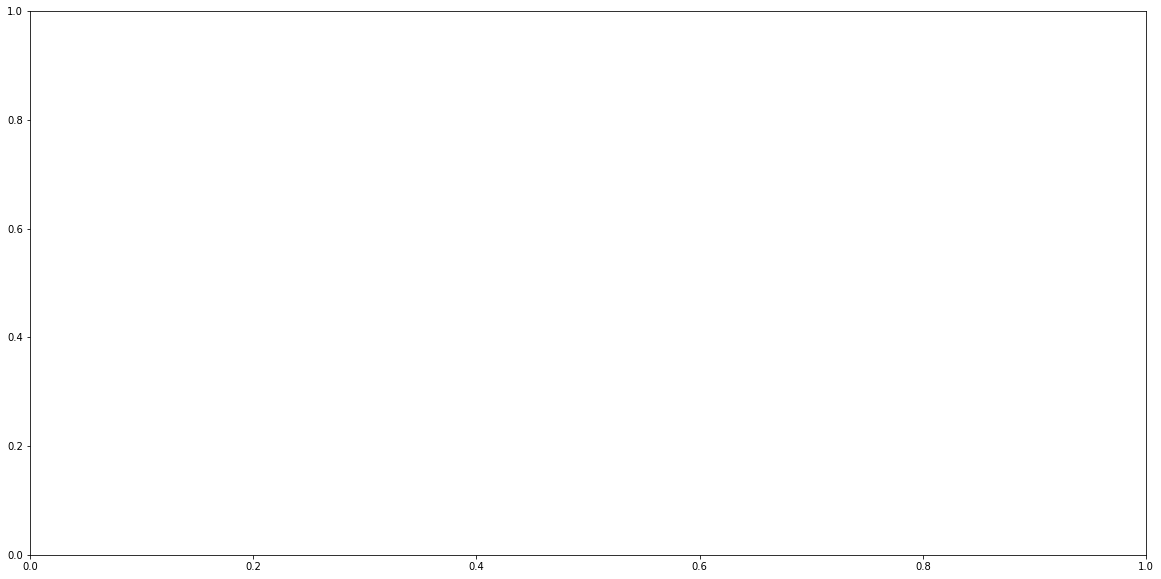

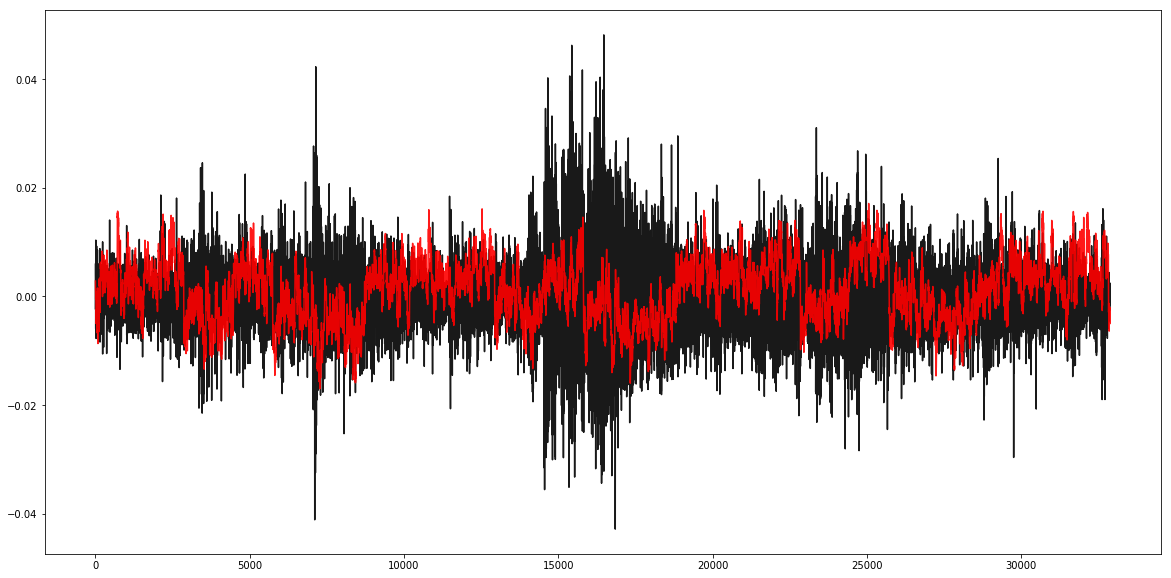

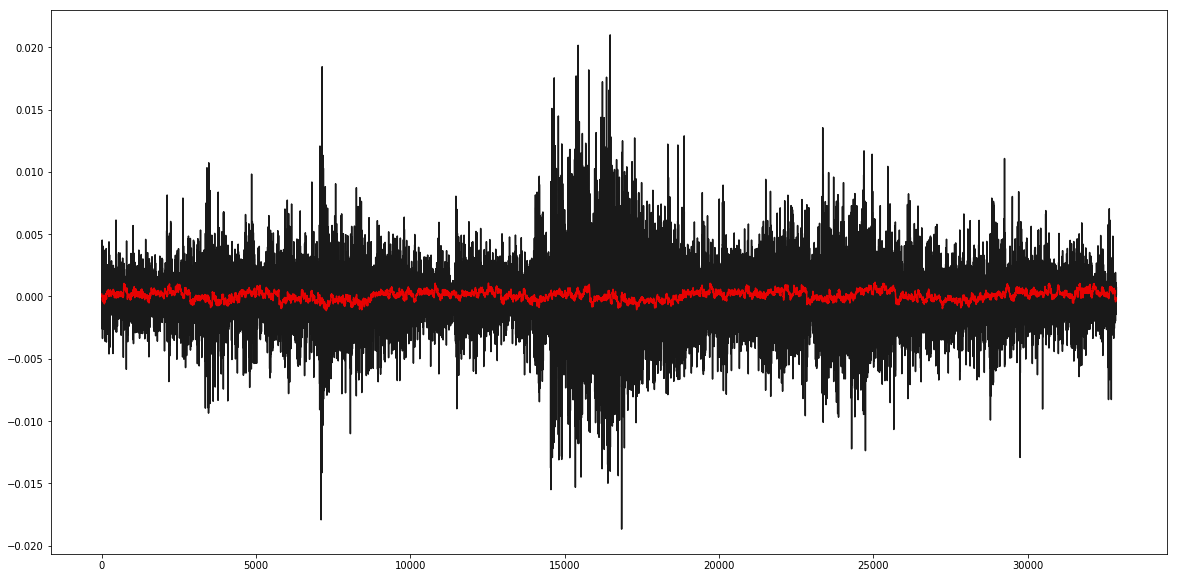

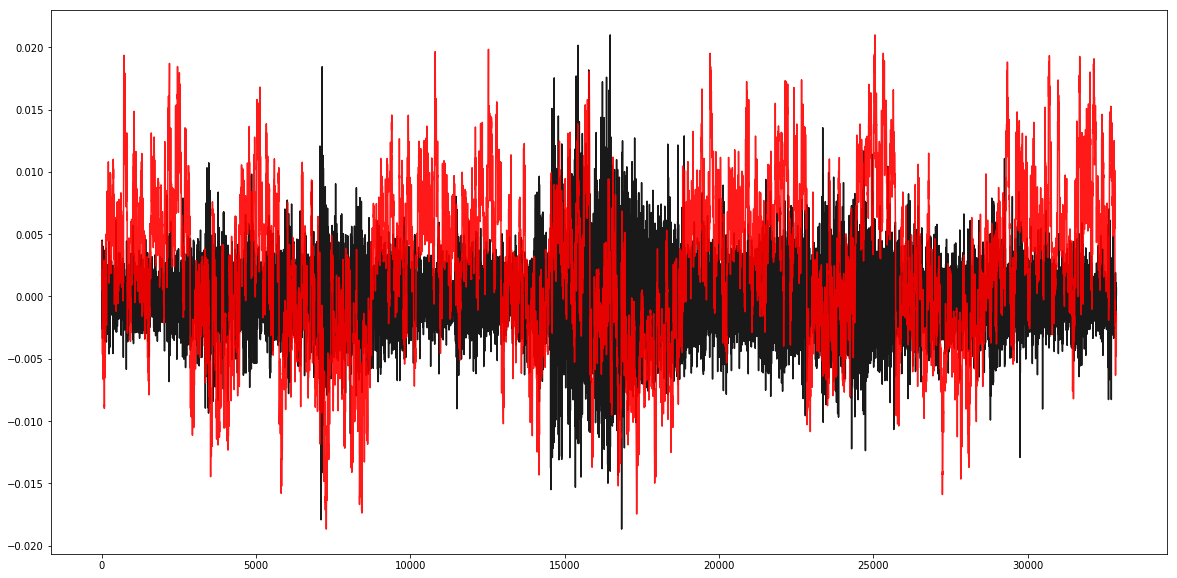

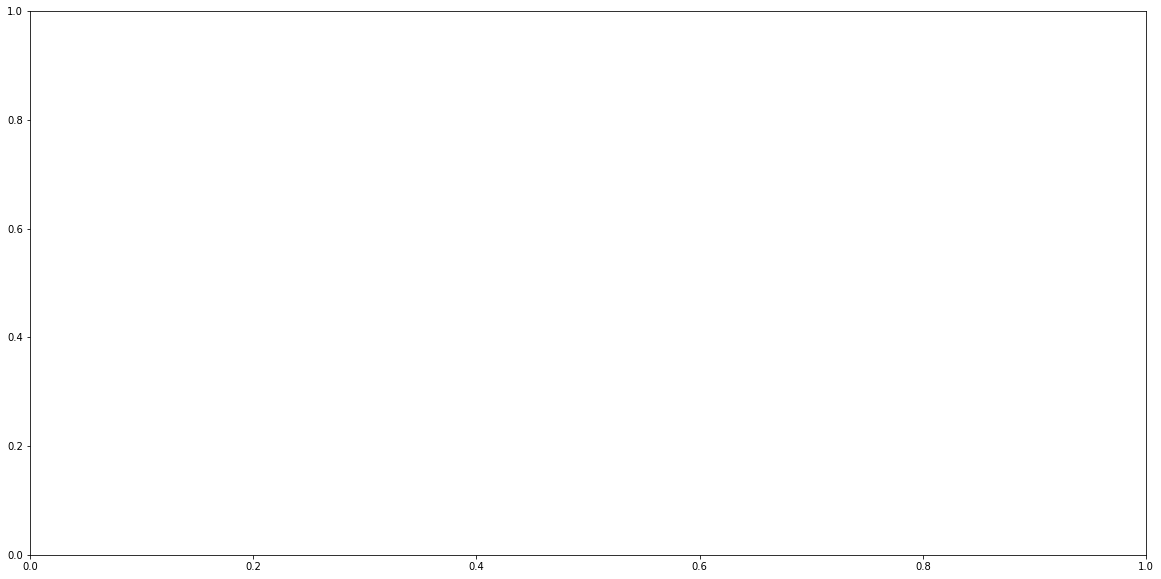

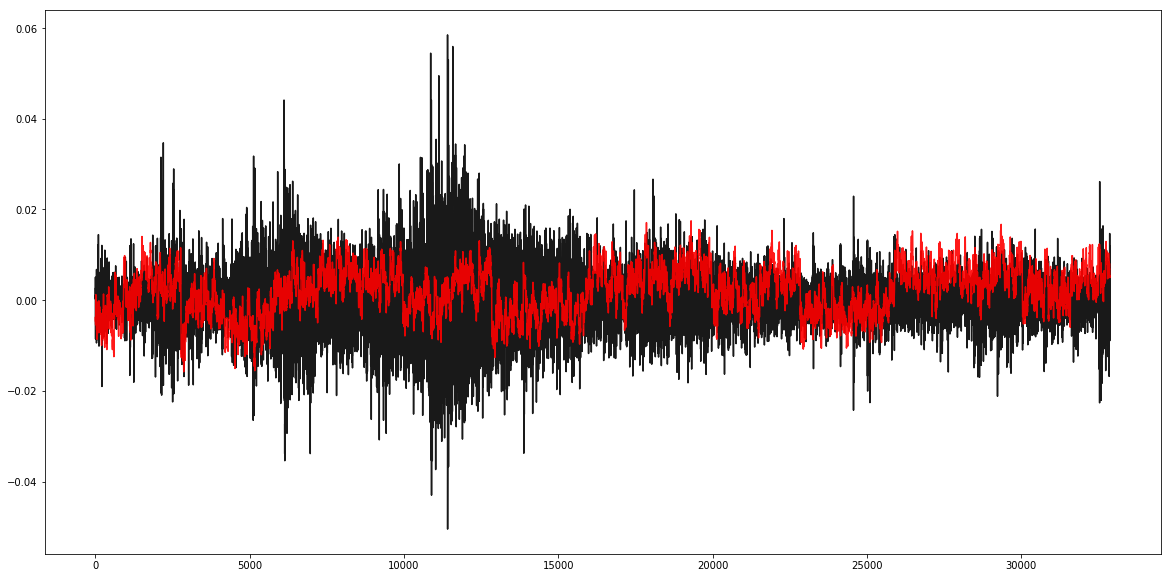

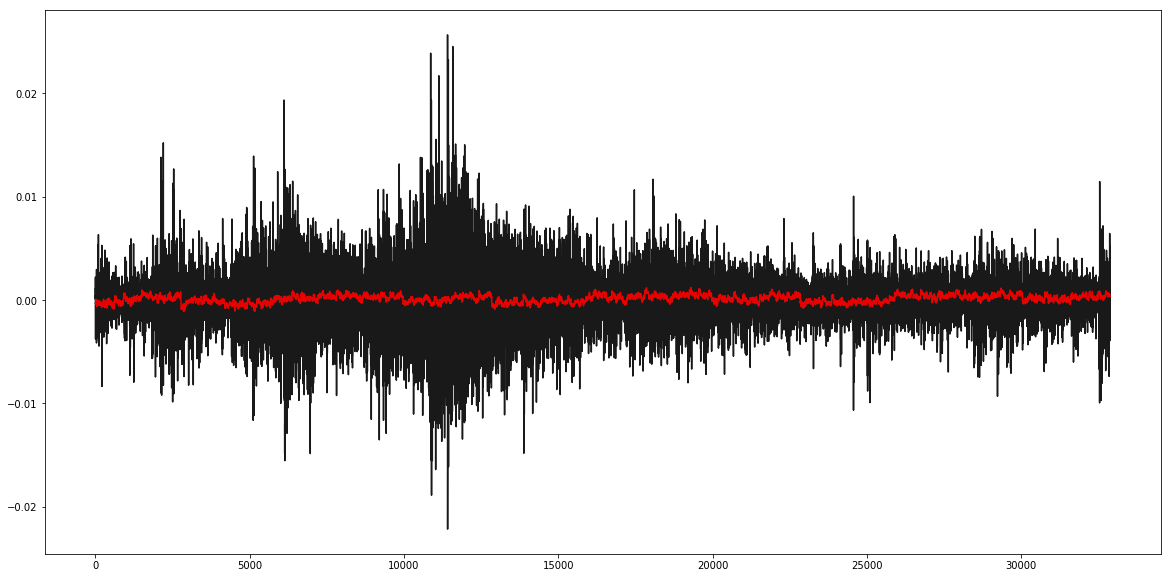

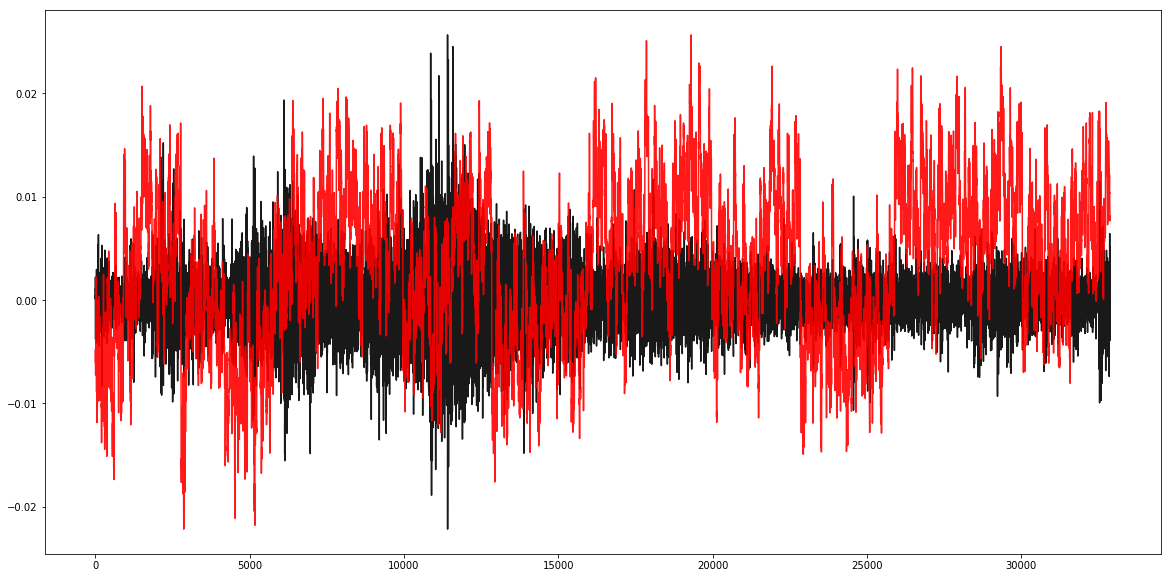

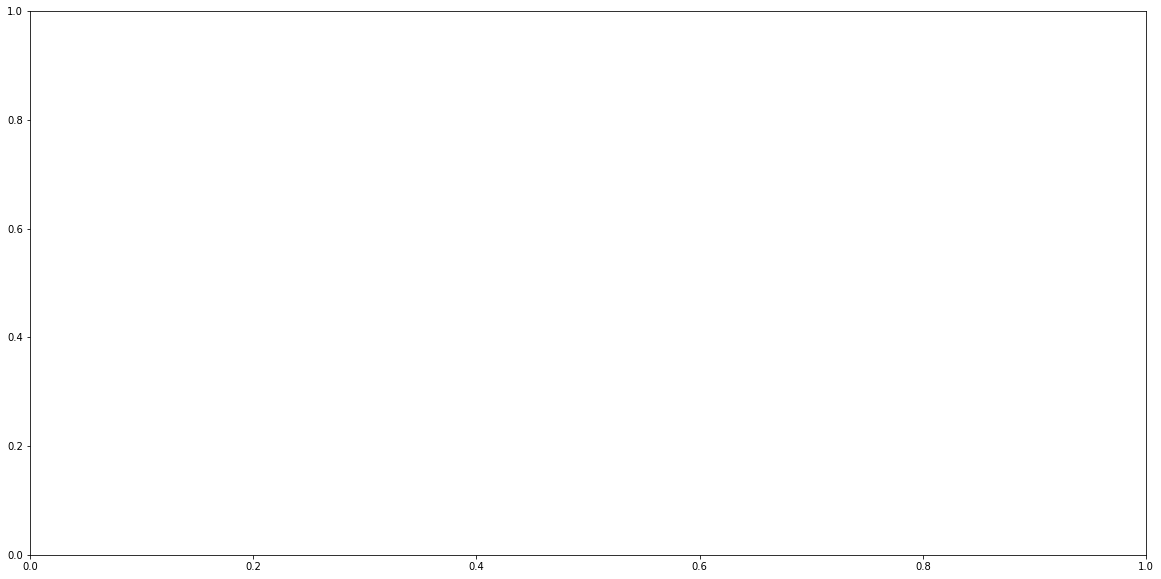

In [34]:
# VISUALIZE
## Plot: 
# Historical price, color coded with train, dev, test
# Historical percent change, color coded with train, dev, test
# Train Loss, Dev Loss
# Actual price vs predicted price (or percent change) for test set
# Example features time series for one day (NOTE: in the preprocessing_final notebook)

if predict_end_of_window:
    timestep_within_window = 0
else:
    timestep_within_window = 29
    
minute_start = 0

print_save_events_props(Y_train.flatten(), Y_dev.flatten(), Y_test.flatten(), evaluate, model_name, model_path)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')
plot_train_dev_losses(history)

minute_end = len(Y_train)
plot_percent_change(evaluate['y_hat_train'], Y_train, timestep_within_window, minute_start, minute_end, predict_end_of_window)

minute_end = len(Y_dev)
plot_percent_change(evaluate['y_hat_dev'], Y_dev, timestep_within_window, minute_start, minute_end, predict_end_of_window)

minute_end = len(Y_test)
plot_percent_change(evaluate['y_hat_test'], Y_test, timestep_within_window, minute_start, minute_end, predict_end_of_window)

window-60_step-1_predEndWindow-False_temporalFeat-False_batch-4096_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-785_dayEnd-None

n_all:   116186
n_train: 58093
n_dev:   29046
n_test:  29046
(58093, 15)
(29046, 15)
(29047, 15)
(58093, 1)
(29046, 1)
(29047, 1)
Train, dev, test shapes:
(58034, 60, 15)
(28987, 60, 15)
(28988, 60, 15)
(58034, 60, 1)
(28987, 60, 1)
(28988, 60, 1)


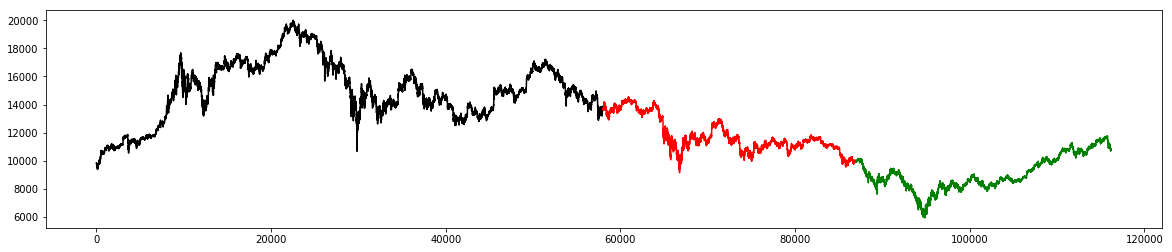

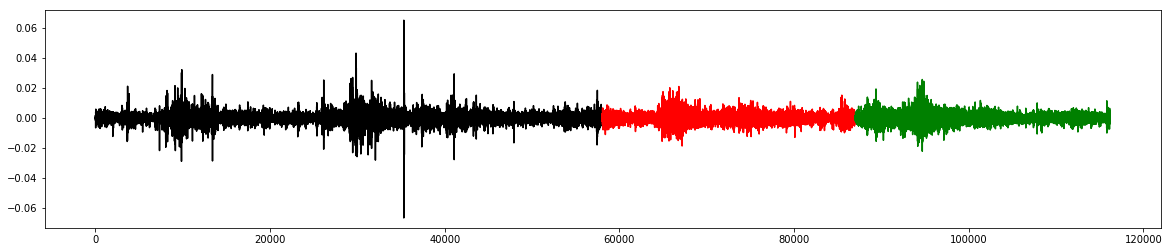

In [37]:
##### MAIN MODEL #####

# HYPERPARAMETERS
window_size = 60
step = 1
predict_end_of_window = False
temporal_features = False

batch_size = 4096 #8192
num_epochs = 30
verbose = 1
loss = 'mean_squared_error'
optimizer = 'adam'
num_LSTM = 3
num_units = [128, 256, 256]
#num_LSTM = 2
#num_units = [256, 256]
dropout = 0.1

path = 'cboe/parquet_preprocessed_BTCUSD_merged'
day_start = 785
day_end = None
percent_train = 0.5

num_units_string = '-'.join([str(u) for u in num_units])

model_name = 'window-%s_step-%s_predEndWindow-%s_temporalFeat-%s_batch-%s_epochs-%s_loss-%s_opt-%s_numLSTMs-%s_numUnits-%s_dropout-%s_dayStart-%s_dayEnd-%s' % (window_size, step, str(predict_end_of_window), str(temporal_features), batch_size, num_epochs, loss, optimizer, num_LSTM, num_units_string, dropout, str(day_start), str(day_end))
print(model_name+'\n')
model_path = 'models/%s' % model_name  

# LOAD DATA
df = load_data(path, day_start, day_end)

# CREATE XY DATA
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = split(df, temporal_features, percent_train)
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = create_all_XY(X_train, X_dev, X_test, Y_train, Y_dev, Y_test,
                                                               window_size, step, predict_end_of_window)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')

In [38]:
# INITIALIZE MODEL
model = initialize_model(X_train, loss, optimizer, num_LSTM, num_units, dropout, predict_end_of_window=predict_end_of_window)

# TRAIN MODEL
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, 
                    validation_data=(X_dev, Y_dev), verbose=verbose, shuffle=False) 

# SAVE MODEL AND HISTORY
save_model_history(model, history, model_path)

Train on 58034 samples, validate on 28987 samples
Epoch 1/30
58034/58034 [==============================] - 9s 148us/step - loss: 0.0090 - val_loss: 6.3350e-04
Epoch 2/30
58034/58034 [==============================] - 7s 121us/step - loss: 2.1982e-04 - val_loss: 1.2877e-04
Epoch 3/30
58034/58034 [==============================] - 7s 121us/step - loss: 7.6938e-05 - val_loss: 3.4318e-05
Epoch 4/30
58034/58034 [==============================] - 7s 121us/step - loss: 2.9297e-05 - val_loss: 3.6763e-05
Epoch 5/30
58034/58034 [==============================] - 7s 121us/step - loss: 1.9147e-05 - val_loss: 1.0356e-05
Epoch 6/30
58034/58034 [==============================] - 7s 121us/step - loss: 1.4037e-05 - val_loss: 9.5160e-06
Epoch 7/30
58034/58034 [==============================] - 7s 121us/step - loss: 1.3016e-05 - val_loss: 1.2180e-05
Epoch 8/30
58034/58034 [==============================] - 7s 121us/step - loss: 1.2228e-05 - val_loss: 1.0773e-05
Epoch 9/30
58034/58034 [==================

In [47]:
# INITIALIZE MODEL
model = initialize_model(X_train, loss, optimizer, num_LSTM, num_units, dropout, predict_end_of_window=predict_end_of_window)

# TRAIN MODEL
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, 
                    validation_data=(X_dev, Y_dev), callbacks=callbacks_list, verbose=verbose, shuffle=True) 

# SAVE MODEL AND HISTORY
save_model_history(model, history, model_path)

Train on 1100005 samples, validate on 61056 samples
Epoch 1/100
 577536/1100005 [==============>...............] - ETA: 1:29 - loss: 0.0011

KeyboardInterrupt: 

In [39]:
# EVALUATE MODEL
print('Evaluating...')
evaluate = evaluate_model(model, history, X_train, X_dev, X_test, Y_train, Y_dev, Y_test, predict_end_of_window)

Evaluating...
Evaluating test loss...
Predicting y_hat_train...
Predicting y_hat_dev...
Predicting y_hat_test...


window-60_step-1_predEndWindow-False_temporalFeat-False_batch-4096_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-785_dayEnd-None

========== EVENT COUNTS AND PROPORTIONS ==========
=== TRAIN ===
Down, Same, Up: [1571829  258335 1651876]
Down, Same, Up: [0.45141038 0.0741907  0.47439892]

=== DEV ===
Down, Same, Up: [785232 136122 817866]
Down, Same, Up: [0.45148515 0.07826612 0.47024873]

=== TEST ===
Down, Same, Up: [787895 144392 806993]
Down, Same, Up: [0.45300067 0.08301826 0.46398107]

========== CORRECTION DIRECTION PREDICTIONS ==========
TRAIN: 0.458422
DEV:   0.452166
TEST:  0.456500

========== FINAL LOSS ==========
TRAIN: 8.0802951571034e-06
DEV:   6.299730407539074e-06
TEST:  6.4831115095884795e-06



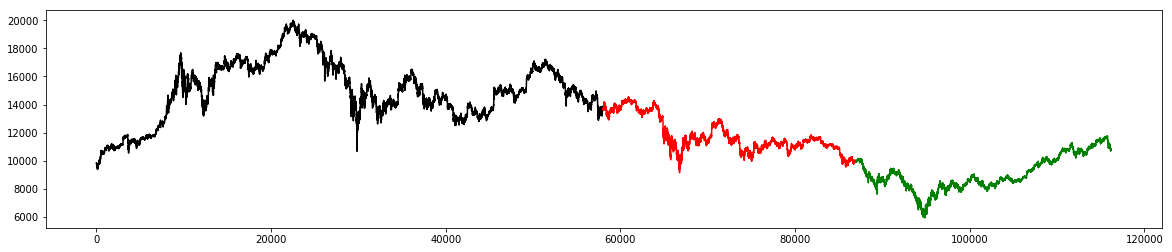

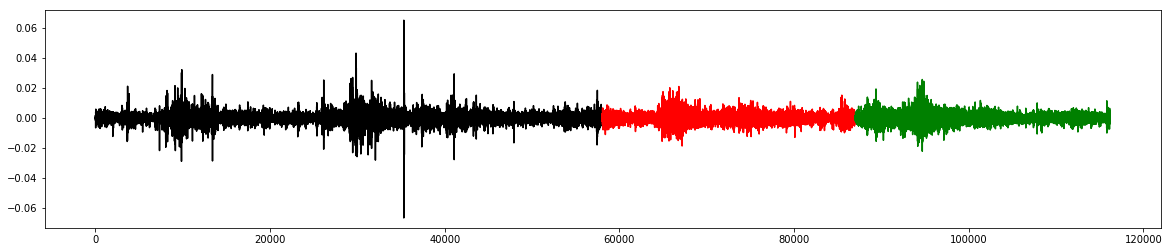

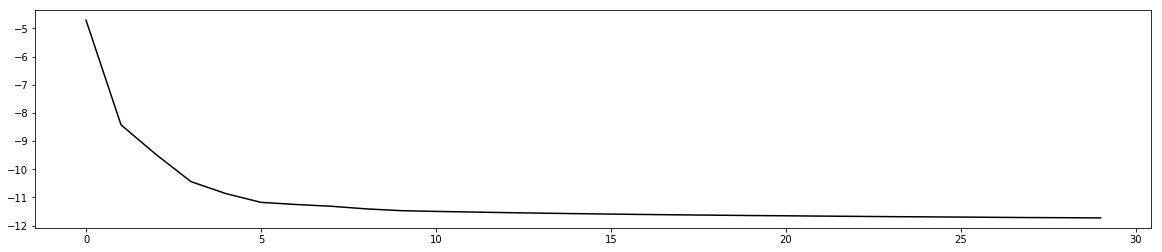

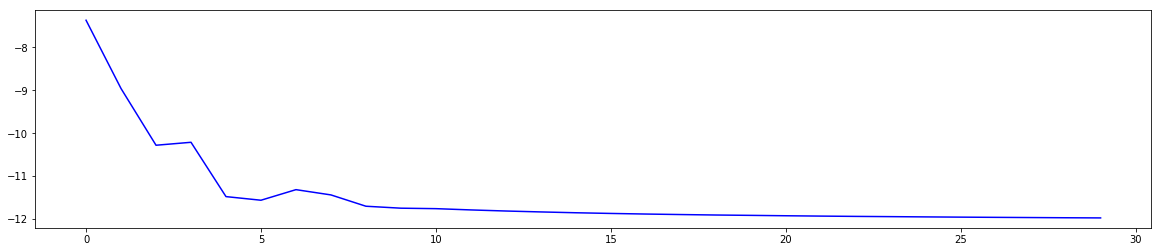

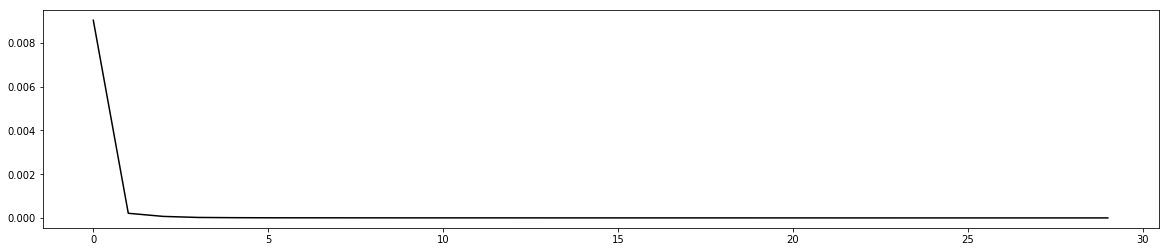

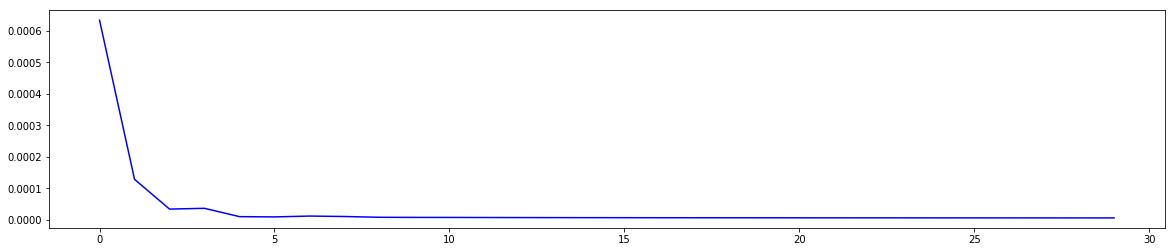

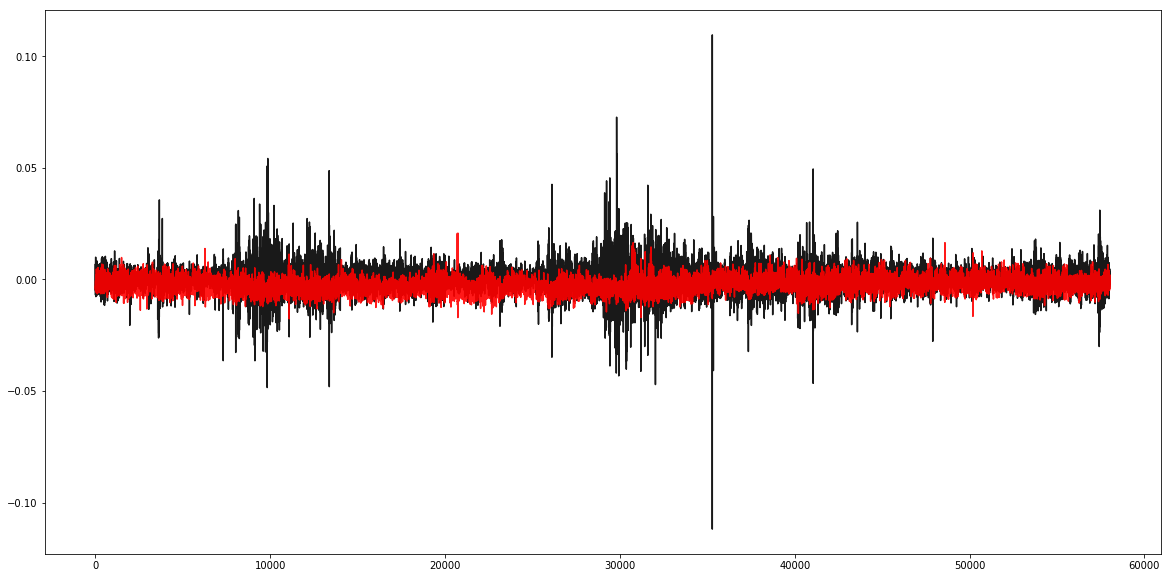

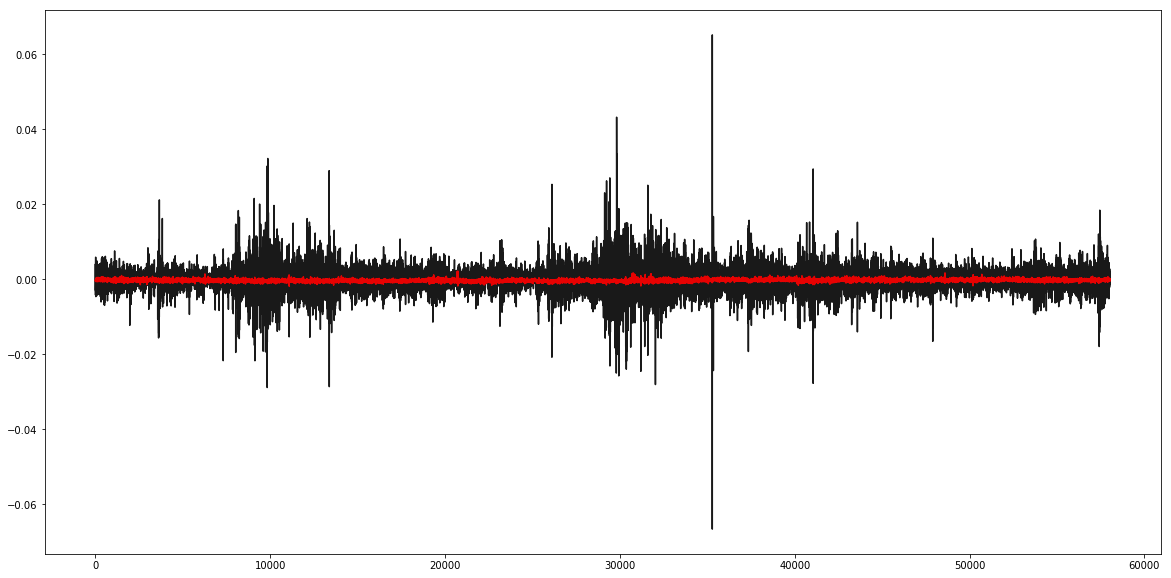

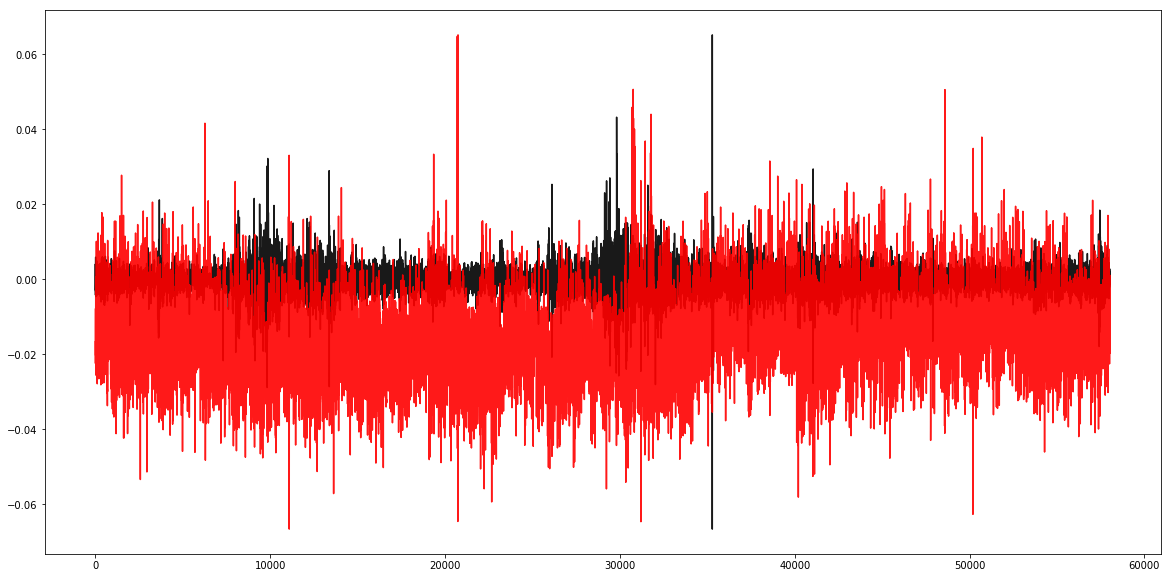

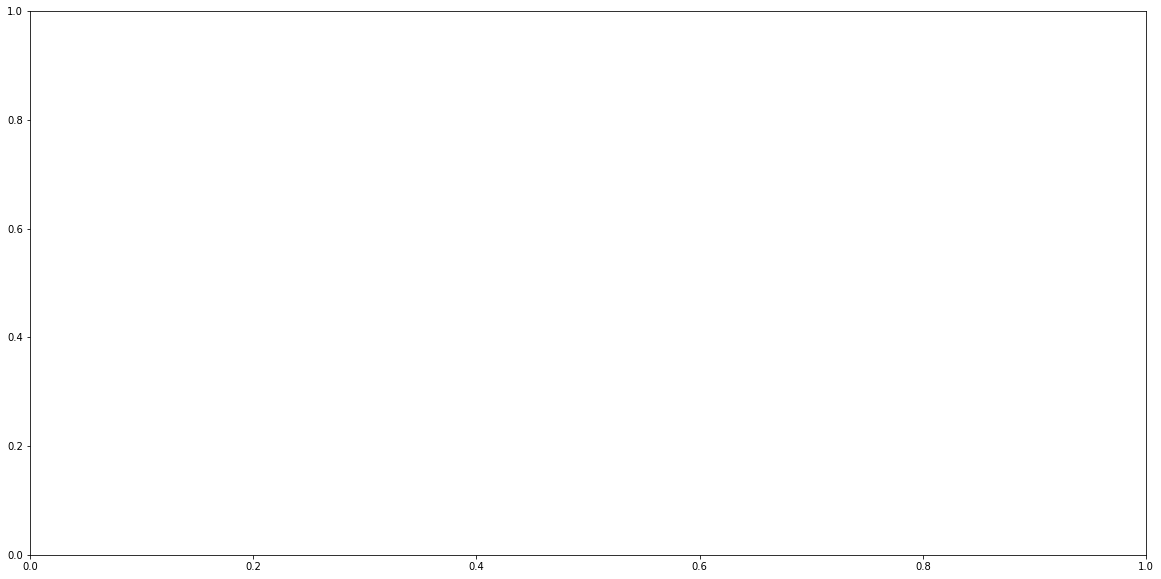

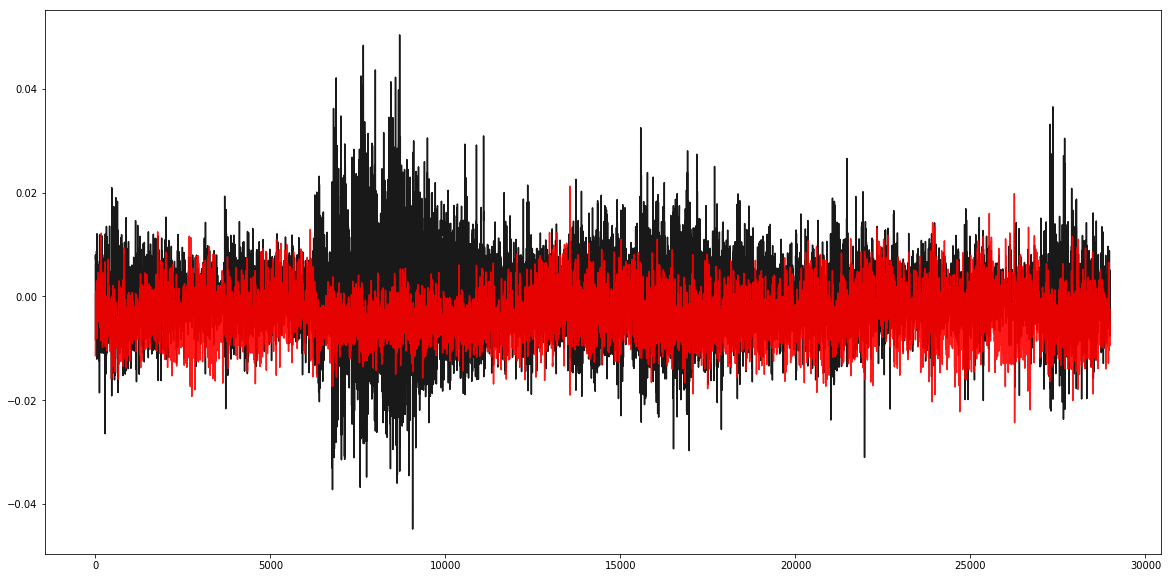

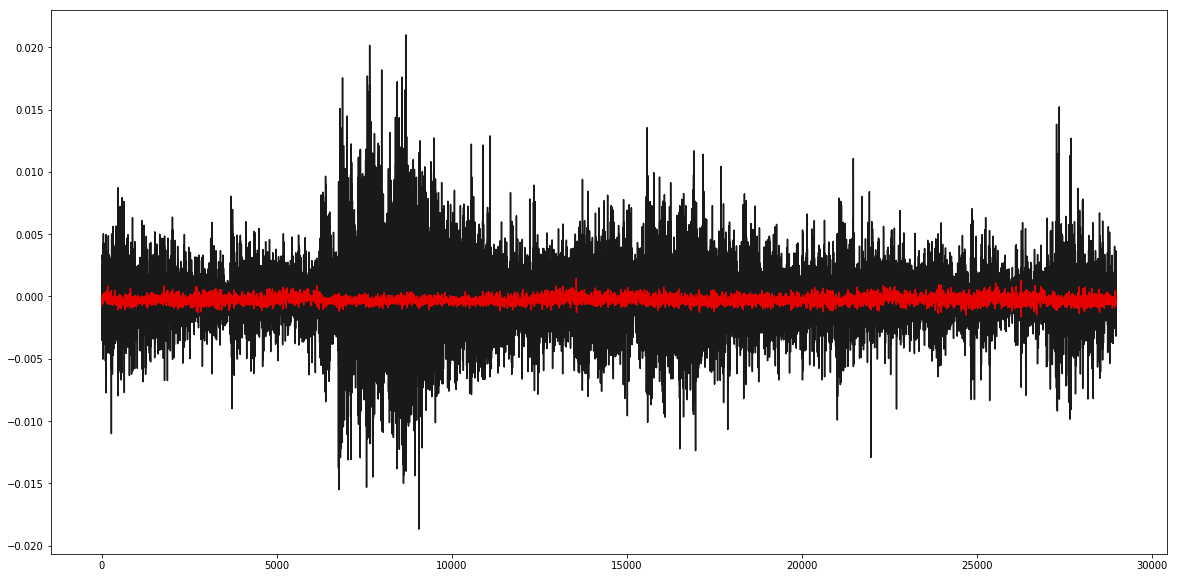

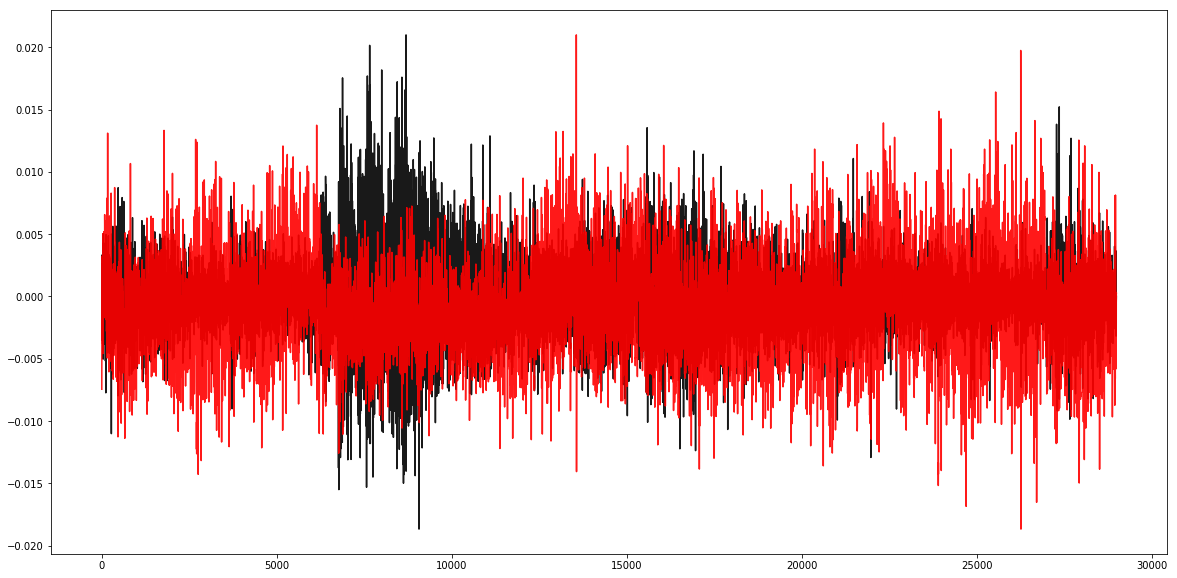

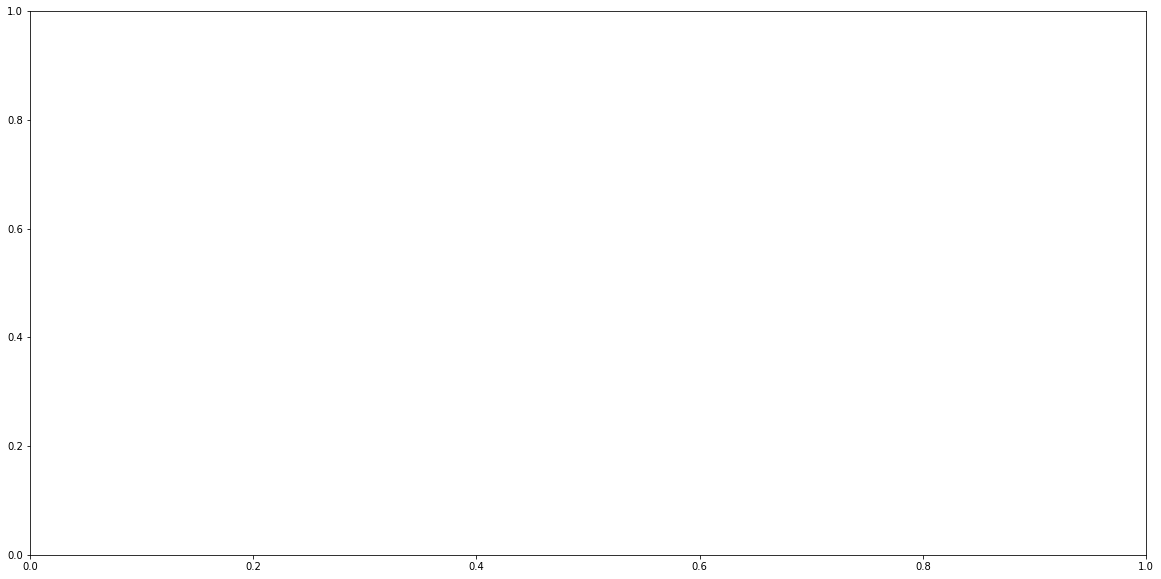

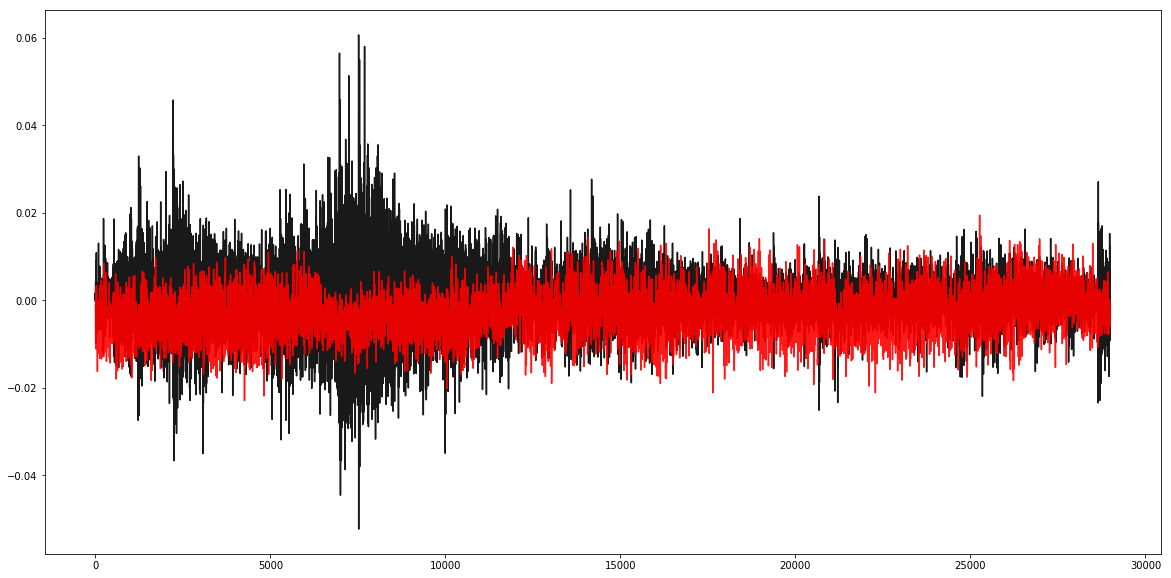

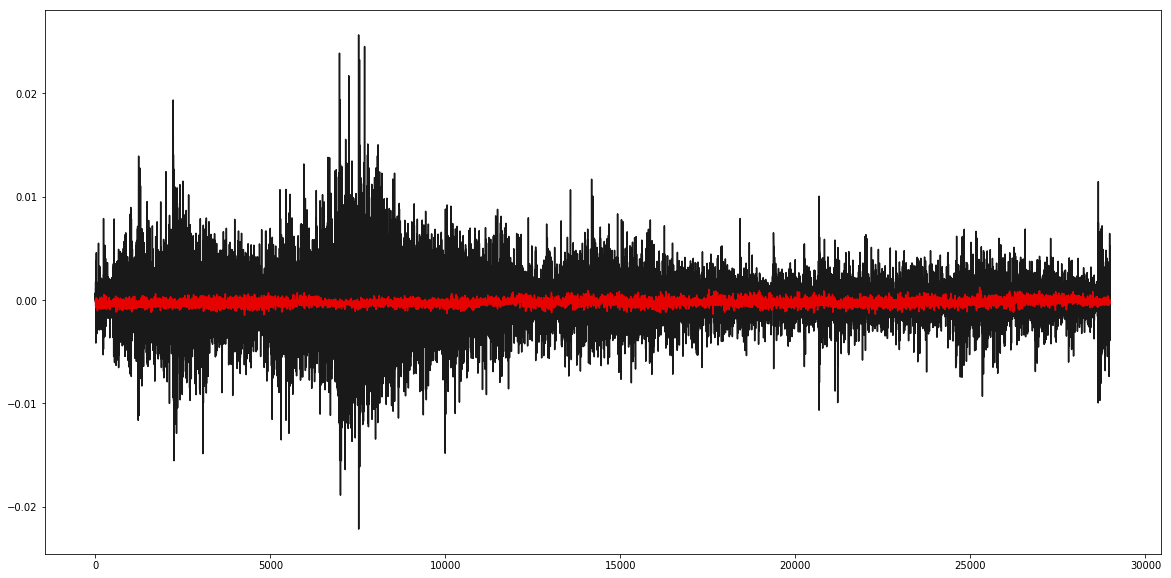

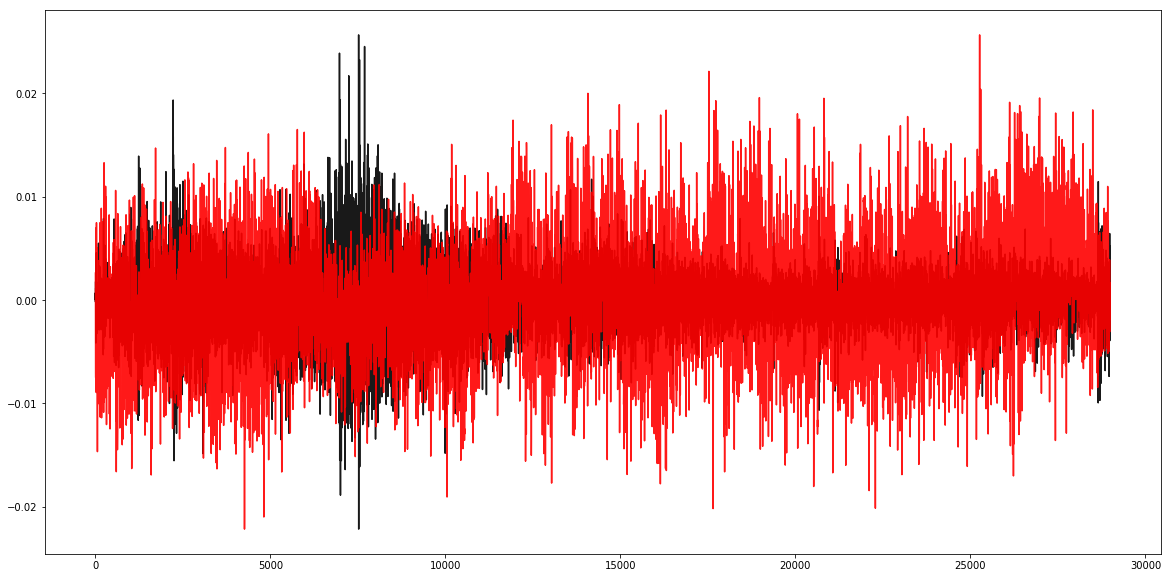

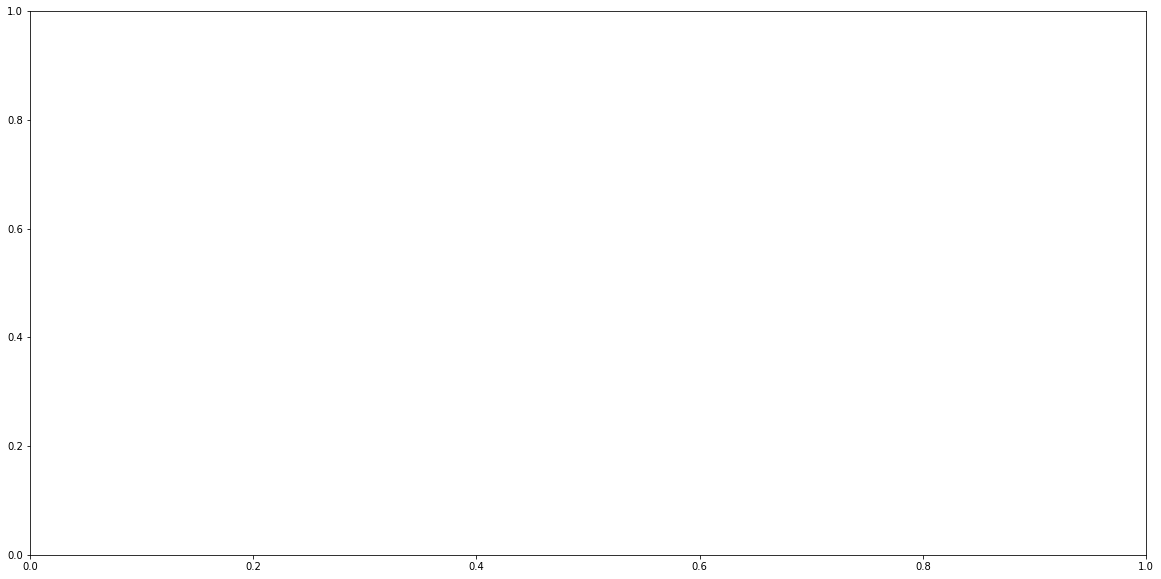

In [40]:
# VISUALIZE
## Plot: 
# Historical price, color coded with train, dev, test
# Historical percent change, color coded with train, dev, test
# Train Loss, Dev Loss
# Actual price vs predicted price (or percent change) for test set
# Example features time series for one day (NOTE: in the preprocessing_final notebook)

if predict_end_of_window:
    timestep_within_window = 0
else:
    timestep_within_window = 29
    
minute_start = 0

print_save_events_props(Y_train.flatten(), Y_dev.flatten(), Y_test.flatten(), evaluate, model_name, model_path)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')
plot_train_dev_losses(history)

minute_end = len(Y_train)
plot_percent_change(evaluate['y_hat_train'], Y_train, timestep_within_window, minute_start, minute_end, predict_end_of_window)

minute_end = len(Y_dev)
plot_percent_change(evaluate['y_hat_dev'], Y_dev, timestep_within_window, minute_start, minute_end, predict_end_of_window)

minute_end = len(Y_test)
plot_percent_change(evaluate['y_hat_test'], Y_test, timestep_within_window, minute_start, minute_end, predict_end_of_window)

window-1440_step-1_predEndWindow-False_temporalFeat-False_batch-128_epochs-15_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-256-256-256_dropout-0.1_dayStart-785_dayEnd-None

n_all:   116186
n_train: 69712
n_dev:   23237
n_test:  23237
(69712, 15)
(23237, 15)
(23237, 15)
(69712, 1)
(23237, 1)
(23237, 1)
Train, dev, test shapes:
(68273, 1440, 15)
(21798, 1440, 15)
(21798, 1440, 15)
(68273, 1440, 1)
(21798, 1440, 1)
(21798, 1440, 1)


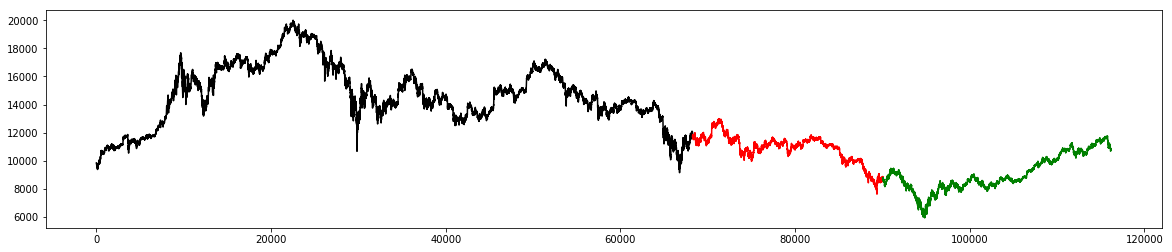

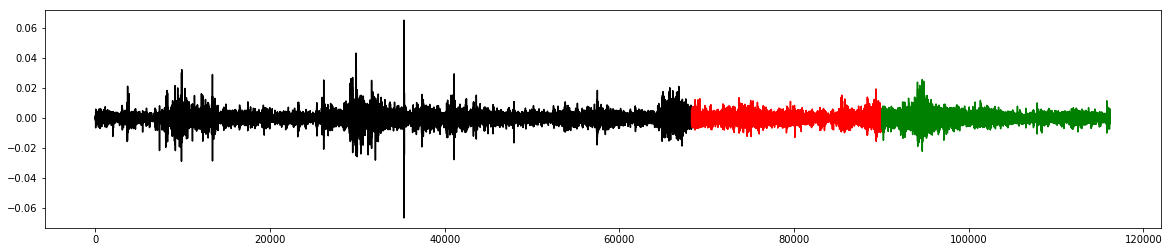

In [31]:
##### MAIN MODEL #####

# HYPERPARAMETERS
window_size = 1440
step = 1
predict_end_of_window = False
temporal_features = False

batch_size = 128 #8192
num_epochs = 15
verbose = 1
loss = 'mean_squared_error'
optimizer = 'adam'
num_LSTM = 3
num_units = [256, 256, 256]
#num_LSTM = 2
#num_units = [256, 256]
dropout = 0.1

path = 'cboe/parquet_preprocessed_BTCUSD_merged'
day_start = 785
day_end = None
percent_train = 0.6

num_units_string = '-'.join([str(u) for u in num_units])

model_name = 'window-%s_step-%s_predEndWindow-%s_temporalFeat-%s_batch-%s_epochs-%s_loss-%s_opt-%s_numLSTMs-%s_numUnits-%s_dropout-%s_dayStart-%s_dayEnd-%s' % (window_size, step, str(predict_end_of_window), str(temporal_features), batch_size, num_epochs, loss, optimizer, num_LSTM, num_units_string, dropout, str(day_start), str(day_end))
print(model_name+'\n')
model_path = 'models/%s' % model_name  

# LOAD DATA
df = load_data(path, day_start, day_end)

# CREATE XY DATA
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = split(df, temporal_features, percent_train)
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = create_all_XY(X_train, X_dev, X_test, Y_train, Y_dev, Y_test,
                                                               window_size, step, predict_end_of_window)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')

In [32]:
# INITIALIZE MODEL
model = initialize_model(X_train, loss, optimizer, num_LSTM, num_units, dropout, predict_end_of_window=predict_end_of_window)

# TRAIN MODEL
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, 
                    validation_data=(X_dev, Y_dev), verbose=verbose, shuffle=False) 

# SAVE MODEL AND HISTORY
save_model_history(model, history, model_path)

Train on 68273 samples, validate on 21798 samples
Epoch 1/15
 1024/68273 [..............................] - ETA: 49:43 - loss: 0.0405

KeyboardInterrupt: 

In [ ]:
# EVALUATE MODEL
print('Evaluating...')
evaluate = evaluate_model(model, history, X_train, X_dev, X_test, Y_train, Y_dev, Y_test, predict_end_of_window)

In [ ]:
# VISUALIZE
## Plot: 
# Historical price, color coded with train, dev, test
# Historical percent change, color coded with train, dev, test
# Train Loss, Dev Loss
# Actual price vs predicted price (or percent change) for test set
# Example features time series for one day (NOTE: in the preprocessing_final notebook)

if predict_end_of_window:
    timestep_within_window = 0
else:
    timestep_within_window = 29
    
minute_start = 0

print_save_events_props(Y_train.flatten(), Y_dev.flatten(), Y_test.flatten(), evaluate, model_name, model_path)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')
plot_train_dev_losses(history)

minute_end = len(Y_train)
plot_percent_change(evaluate['y_hat_train'], Y_train, timestep_within_window, minute_start, minute_end, predict_end_of_window)

minute_end = len(Y_dev)
plot_percent_change(evaluate['y_hat_dev'], Y_dev, timestep_within_window, minute_start, minute_end, predict_end_of_window)

minute_end = len(Y_test)
plot_percent_change(evaluate['y_hat_test'], Y_test, timestep_within_window, minute_start, minute_end, predict_end_of_window)

In [36]:
paths = sorted(glob('models/*'))
paths

['models/window-30_step-1_batch-8192_epochs-50_loss-mse_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-401_dayEnd-None',
 'models/window-60_step-1_batch-8192_epochs-50_loss-mean_squared_error_opt-adam_numLSTMs-2_numUnits-[256, 256]_dropout-0.1',
 'models/window-60_step-1_predEndWindow-False_temporalFeat-False_batch-4096_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-785_dayEnd-None',
 'models/window-60_step-1_predEndWindow-False_temporalFeat-True_batch-4096_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-401_dayEnd-None',
 'models/window-60_step-1_predEndWindow-True_batch-4096_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-401_dayEnd-None',
 'models/window-60_step-1_predEndWindow-True_batch-4096_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-401_dayEnd-None_20180321123940481133',

In [37]:
file = 'models/window-60_step-1_predEndWindow-False_temporalFeat-True_batch-4096_epochs-30_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-128-256-256_dropout-0.1_dayStart-401_dayEnd-None'

In [38]:
restored_history = pickle.load( open( file+"/trainHistoryDict", "rb" ) )

In [39]:
restored_history['loss']

[0.0013295086801477112,
 2.8544765306902116e-05,
 9.815547228642517e-06,
 9.33995154924169e-06,
 9.458272596985134e-06,
 9.798957299359768e-06,
 9.982231540162962e-06,
 1.1582137219604749e-05,
 1.315338271085747e-05,
 1.3244753255616263e-05,
 1.2100966278057766e-05,
 1.1326488191372323e-05,
 1.1648964109483853e-05,
 1.1446996148031587e-05,
 1.0969933590453943e-05,
 1.2007244875001292e-05,
 1.2872053509154086e-05,
 1.5059398479635953e-05,
 1.2103332302550832e-05,
 1.4507730347926693e-05,
 1.2994994949141768e-05,
 1.2648640805245196e-05,
 1.5681230328830015e-05,
 1.4863788198930323e-05,
 1.3594880325703787e-05,
 1.3666427717782781e-05,
 1.2514633311504497e-05,
 8.770314063703703e-06,
 5.821357270928167e-06,
 4.959991545332069e-06]

Text(0.5,1,'Training Loss')

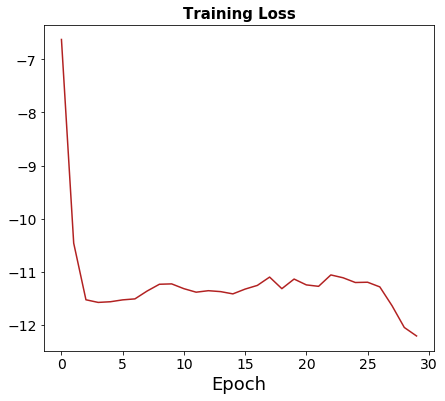

In [67]:
vals = np.log(restored_history['loss'])
new_df = pd.DataFrame(vals, columns=['loss'])
title = 'Training Loss'
new_df.plot(y = 'loss', figsize=(7,6), title=title, fontsize=14, legend=False, color='firebrick')
plt.xlabel('Epoch', fontsize=18)
plt.title(title, fontsize=15, fontweight='bold')

Text(0.5,1,'Dev Loss')

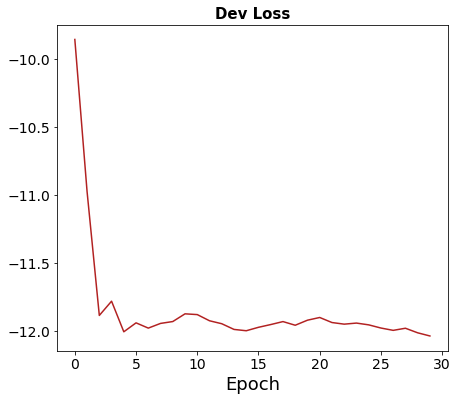

In [68]:
vals = np.log(restored_history['val_loss'])
new_df = pd.DataFrame(vals, columns=['loss'])
title = 'Dev Loss'
new_df.plot(y = 'loss', figsize=(7,6), title=title, fontsize=14, legend=False, color='firebrick')
plt.xlabel('Epoch', fontsize=18)
plt.title(title, fontsize=15, fontweight='bold')

In [47]:
np.log(restored_history['loss'])

array([ -6.62294582, -10.46403699, -11.53154298, -11.58120949,
       -11.56862079, -11.53323458, -11.51470389, -11.36604654,
       -11.23883159, -11.23190906, -11.32222525, -11.38836649,
       -11.3602933 , -11.37778321, -11.42035234, -11.33000035,
       -11.26045199, -11.10350828, -11.32202975, -11.14082892,
       -11.25094628, -11.27796079, -11.06304608, -11.11658263,
       -11.20581728, -11.20056826, -11.28861193, -11.64413794,
       -12.05397712, -12.21410652])

window-60_step-1_predEndWindow-False_temporalFeat-True_batch-4096_epochs-100_loss-mean_squared_error_opt-adam_numLSTMs-3_numUnits-512-512-256_dropout-0.1_dayStart-0_dayEnd-None

n_all:   1222293
n_train: 1100064
n_dev:   61115
n_test:  61115
(1100064, 58)
(61115, 58)
(61114, 58)
(1100064, 1)
(61115, 1)
(61114, 1)
Train, dev, test shapes:
(1100005, 60, 58)
(61056, 60, 58)
(61055, 60, 58)
(1100005, 60, 1)
(61056, 60, 1)
(61055, 60, 1)


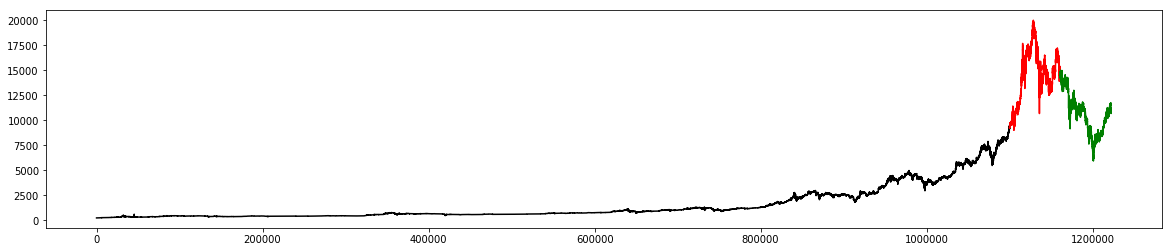

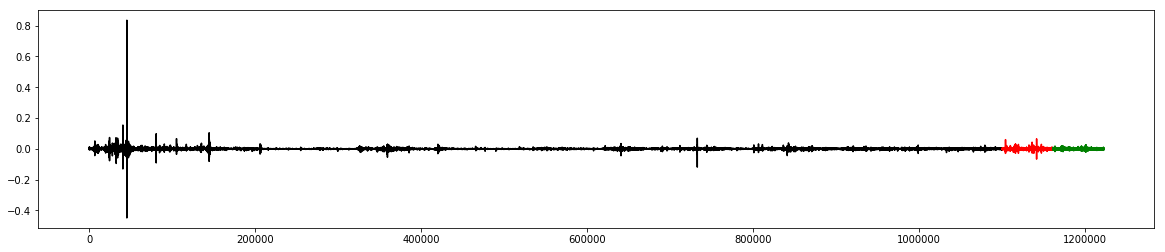

In [29]:
##### MAIN MODEL #####

# HYPERPARAMETERS
window_size = 60
step = 1
predict_end_of_window = False
temporal_features = True

batch_size = 4096#2048 #8192
num_epochs = 100
verbose = 1
loss = 'mean_squared_error'
optimizer = 'adam'
num_LSTM = 3
num_units = [512, 256, 256]
#num_LSTM = 2
#num_units = [256, 256]
dropout = 0.1

path = 'cboe/parquet_preprocessed_BTCUSD_merged'
day_start = 0
day_end = None
percent_train = 0.9

num_units_string = '-'.join([str(u) for u in num_units])

model_name = 'window-%s_step-%s_predEndWindow-%s_temporalFeat-%s_batch-%s_epochs-%s_loss-%s_opt-%s_numLSTMs-%s_numUnits-%s_dropout-%s_dayStart-%s_dayEnd-%s' % (window_size, step, str(predict_end_of_window), str(temporal_features), batch_size, num_epochs, loss, optimizer, num_LSTM, num_units_string, dropout, str(day_start), str(day_end))
print(model_name+'\n')
model_path = 'models/%s' % model_name  

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=15)
callbacks_list = [early_stop]

# LOAD DATA
df = load_data(path, day_start, day_end)

# CREATE XY DATA
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = split(df, temporal_features, percent_train)
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = create_all_XY(X_train, X_dev, X_test, Y_train, Y_dev, Y_test,
                                                               window_size, step, predict_end_of_window)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')

In [30]:
# INITIALIZE MODEL
model = initialize_model(X_train, loss, optimizer, num_LSTM, num_units, dropout, predict_end_of_window=predict_end_of_window)

# TRAIN MODEL
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, 
                    validation_data=(X_dev, Y_dev), callbacks=callbacks_list, verbose=verbose, shuffle=True) 

# SAVE MODEL AND HISTORY
save_model_history(model, history, model_path)

Train on 1100005 samples, validate on 61056 samples
Epoch 1/100


ResourceExhaustedError: OOM when allocating tensor with shape[60,4096,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/gradients/lstm_3/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGatherV3 = TensorArrayGatherV3[_class=["loc:@lstm_3/transpose"], dtype=DT_FLOAT, element_shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/lstm_3/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGrad/TensorArrayGradV3, lstm_3/TensorArrayUnstack/range, training/Adam/gradients/lstm_3/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGrad/gradient_flow)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training/Adam/gradients/lstm_3/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGatherV3', defined at:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-74e04270bdd0>", line 6, in <module>
    validation_data=(X_dev, Y_dev), callbacks=callbacks_list, verbose=verbose, shuffle=True)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/models.py", line 963, in fit
    validation_steps=validation_steps)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py", line 1689, in fit
    self._make_train_function()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py", line 440, in get_updates
    grads = self.get_gradients(loss, params)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py", line 78, in get_gradients
    grads = K.gradients(loss, params)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2512, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 609, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 375, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 609, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/tensor_array_grad.py", line 186, in _TensorArrayScatterGrad
    grad = g.gather(indices)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/tensor_array_ops.py", line 908, in gather
    return self._implementation.gather(indices, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/tensor_array_ops.py", line 304, in gather
    element_shape=element_shape)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gen_data_flow_ops.py", line 4211, in _tensor_array_gather_v3
    flow_in=flow_in, dtype=dtype, element_shape=element_shape, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'lstm_3/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3', defined at:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 17 identical lines from previous traceback]
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-74e04270bdd0>", line 2, in <module>
    model = initialize_model(X_train, loss, optimizer, num_LSTM, num_units, dropout, predict_end_of_window=predict_end_of_window)
  File "<ipython-input-12-c3170873b7f9>", line 27, in initialize_model
    model.add(LSTM(num_units[2], return_sequences=True))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/models.py", line 492, in add
    output_tensor = layer(self.outputs[0])
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/layers/recurrent.py", line 499, in __call__
    return super(RNN, self).__call__(inputs, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/layers/recurrent.py", line 2063, in call
    initial_state=initial_state)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/layers/recurrent.py", line 608, in call
    input_length=timesteps)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2688, in rnn
    input_ta = input_ta.unstack(inputs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/util/tf_should_use.py", line 118, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/tensor_array_ops.py", line 942, in unstack
    return self._implementation.unstack(value, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/util/tf_should_use.py", line 118, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/tensor_array_ops.py", line 332, in unstack
    indices=math_ops.range(0, num_elements), value=value, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/util/tf_should_use.py", line 118, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/tensor_array_ops.py", line 348, in scatter
    name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gen_data_flow_ops.py", line 4605, in _tensor_array_scatter_v3
    flow_in=flow_in, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[60,4096,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/gradients/lstm_3/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGatherV3 = TensorArrayGatherV3[_class=["loc:@lstm_3/transpose"], dtype=DT_FLOAT, element_shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/lstm_3/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGrad/TensorArrayGradV3, lstm_3/TensorArrayUnstack/range, training/Adam/gradients/lstm_3/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGrad/gradient_flow)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
# EVALUATE MODEL
print('Evaluating...')
evaluate = evaluate_model(model, history, X_train, X_dev, X_test, Y_train, Y_dev, Y_test, predict_end_of_window)

In [ ]:
# VISUALIZE
## Plot: 
# Historical price, color coded with train, dev, test
# Historical percent change, color coded with train, dev, test
# Train Loss, Dev Loss
# Actual price vs predicted price (or percent change) for test set
# Example features time series for one day (NOTE: in the preprocessing_final notebook)

if predict_end_of_window:
    timestep_within_window = 0
else:
    timestep_within_window = window-1
    
minute_start = 0

print_save_events_props(Y_train.flatten(), Y_dev.flatten(), Y_test.flatten(), evaluate, model_name, model_path)
plot_price(df, X_train, X_dev, field='current_price')
plot_price(df, X_train, X_dev, field='percent_change')
plot_train_dev_losses(history)

minute_end = len(Y_train)
plot_percent_change(evaluate['y_hat_train'], Y_train, timestep_within_window, minute_start, minute_end, predict_end_of_window)

minute_end = len(Y_dev)
plot_percent_change(evaluate['y_hat_dev'], Y_dev, timestep_within_window, minute_start, minute_end, predict_end_of_window)

minute_end = len(Y_test)
plot_percent_change(evaluate['y_hat_test'], Y_test, timestep_within_window, minute_start, minute_end, predict_end_of_window)

In [35]:
def mse(time_series):
    total_squared_error = 0
    total_absolute_error = 0
    prev_obv = time_series[0]
    for obv in time_series[1:]:
        total_squared_error += (obv - prev_obv)**2
        total_absolute_error += abs(obv - prev_obv)
        prev_obv = obv
    num_predictions = len(time_series) - 1
    mean_squared_error = total_squared_error / num_predictions
    mean_absolute_error = total_absolute_error / num_predictions
    root_mean_squared_error = np.sqrt(mean_squared_error)
    print('=== baseline ===')
    print('total squared error')
    print(total_squared_error)
    print('total absolute error')
    print(total_absolute_error)
    print('mean squared error')
    print(mean_squared_error)
    print('mean absolute error')
    print(mean_absolute_error) 
    print('root mean squared error')
    print(root_mean_squared_error) 
    print()

In [33]:
# LOAD DATA
df = load_data(path, day_start, day_end)
all_Y = df['current_price']

In [36]:
mse(all_Y)

KeyboardInterrupt: 

In [44]:
MSE = np.sum((np.array(all_Y[:-1])-np.array(all_Y[1:]))**2) / len(all_Y[:-1])
RMSE = np.sqrt(MSE)
print('MSE:', MSE)
print('RMSE:', RMSE)

MSE: 100.01212236096141
RMSE: 10.00060609968023


In [45]:
Y_test.shape

(61055, 60, 1)

In [46]:
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = split(df, temporal_features, percent_train)

n_all:   1222293
n_train: 1100064
n_dev:   61115
n_test:  61115
(1100064, 58)
(61115, 58)
(61114, 58)
(1100064, 1)
(61115, 1)
(61114, 1)


In [49]:
Y = Y_train
MSE = np.sum((np.array(Y[:-1])-np.array(Y[1:]))**2) / len(Y[:-1])
RMSE = np.sqrt(MSE)
print('MSE:', MSE)
print('RMSE:', RMSE)

MSE: 4.012318910301588e-06
RMSE: 0.002003077360039194


In [50]:
Y = Y_dev
MSE = np.sum((np.array(Y[:-1])-np.array(Y[1:]))**2) / len(Y[:-1])
RMSE = np.sqrt(MSE)
print('MSE:', MSE)
print('RMSE:', RMSE)

MSE: 1.1753547518151193e-05
RMSE: 0.003428344719854057


In [51]:
Y = Y_test
MSE = np.sum((np.array(Y[:-1])-np.array(Y[1:]))**2) / len(Y[:-1])
RMSE = np.sqrt(MSE)
print('MSE:', MSE)
print('RMSE:', RMSE)

MSE: 1.2708207093401233e-05
RMSE: 0.0035648572332424803


In [52]:
losss = 1.799e-6

In [53]:
np.sqrt(losss)

0.001341268056728408

In [66]:
#per row: train, dev, test loss
losss = np.array([[1.690e-6, 5.907e-6, 5.893e-6],
[1.673e-6, 5.79e-6, 5.865e-6],
[1.925e-6, 1.043e-5, 1.18e-6],
[1.959e-6, 5.909e-6, 5.97e-6],
[1.694e-6, 6.255e-6, 6.31e-6],
[1.799e-6, 5.791e-6, 5.94e-6],
[1.822e-6, 1.00e-5, 1.09e-5],
[1.718e-5, 6.934e-5, 6.988e-5]])

In [67]:
np.sqrt(losss.mean(axis=0, keepdims=True))

array([[0.00192815, 0.00386364, 0.00374062]])

array([[3.717750e-06, 1.492775e-05, 1.399225e-05]])

0.0024308434750102688